# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [138]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


KeyboardInterrupt: 

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

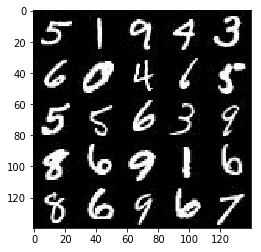

In [39]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [40]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

ValueError: zero-size array to reduction operation minimum which has no identity

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [41]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [42]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_tensor = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_tensor, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [103]:
def discriminator(images, reuse=False, alpha=0.02):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [108]:
def generator(z, out_channel_dim, is_train=True, alpha=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [109]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.02):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [110]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [111]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [136]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        # model_inputs(image_width, image_height, image_channels, z_dim)
        self.input_real, self.input_z, lr = model_inputs(real_size[1], real_size[2], real_size[3], z_size)
        # lr = learning_rate
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[3], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
        
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    net = GAN(data_shape, z_dim, learning_rate, beta1=beta1) 
    
    show_every = 100
    print_every = 10
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, net.input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3248... Generator Loss: 0.1671
Epoch 1/2... Discriminator Loss: 1.2608... Generator Loss: 0.4086
Epoch 1/2... Discriminator Loss: 0.5734... Generator Loss: 2.3382
Epoch 1/2... Discriminator Loss: 0.0832... Generator Loss: 3.9972
Epoch 1/2... Discriminator Loss: 0.4090... Generator Loss: 1.1890
Epoch 1/2... Discriminator Loss: 0.2941... Generator Loss: 1.8398
Epoch 1/2... Discriminator Loss: 0.3325... Generator Loss: 1.4264
Epoch 1/2... Discriminator Loss: 0.5054... Generator Loss: 1.1142
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 0.5385
Epoch 1/2... Discriminator Loss: 2.0621... Generator Loss: 0.1766


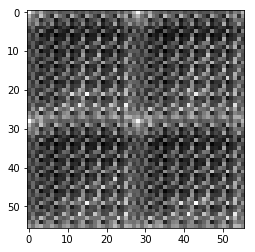

Epoch 1/2... Discriminator Loss: 2.7889... Generator Loss: 0.0822
Epoch 1/2... Discriminator Loss: 1.9419... Generator Loss: 0.3300
Epoch 1/2... Discriminator Loss: 2.2335... Generator Loss: 0.4269
Epoch 1/2... Discriminator Loss: 3.1939... Generator Loss: 0.0524
Epoch 1/2... Discriminator Loss: 1.0203... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 0.6048... Generator Loss: 1.2535
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 1.0061
Epoch 1/2... Discriminator Loss: 2.1466... Generator Loss: 0.2029
Epoch 1/2... Discriminator Loss: 2.2318... Generator Loss: 0.1574
Epoch 1/2... Discriminator Loss: 1.9129... Generator Loss: 0.2129


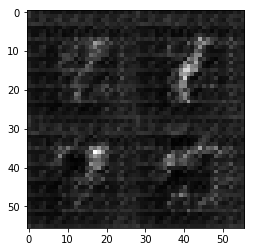

Epoch 1/2... Discriminator Loss: 0.4686... Generator Loss: 1.3585
Epoch 1/2... Discriminator Loss: 0.8702... Generator Loss: 0.9190
Epoch 1/2... Discriminator Loss: 0.9874... Generator Loss: 0.7425
Epoch 1/2... Discriminator Loss: 1.2638... Generator Loss: 5.2095
Epoch 1/2... Discriminator Loss: 1.7767... Generator Loss: 0.3429
Epoch 1/2... Discriminator Loss: 0.2668... Generator Loss: 2.0454
Epoch 1/2... Discriminator Loss: 2.4968... Generator Loss: 0.1311
Epoch 1/2... Discriminator Loss: 1.5754... Generator Loss: 0.3254
Epoch 1/2... Discriminator Loss: 0.6001... Generator Loss: 1.3263
Epoch 1/2... Discriminator Loss: 2.3047... Generator Loss: 0.1270


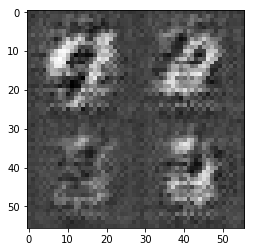

Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.7937... Generator Loss: 0.2204
Epoch 1/2... Discriminator Loss: 0.3608... Generator Loss: 2.1333
Epoch 1/2... Discriminator Loss: 0.7139... Generator Loss: 1.2351
Epoch 1/2... Discriminator Loss: 1.3391... Generator Loss: 0.4395
Epoch 1/2... Discriminator Loss: 0.5100... Generator Loss: 1.4712
Epoch 1/2... Discriminator Loss: 0.7408... Generator Loss: 0.8758
Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 0.6504
Epoch 1/2... Discriminator Loss: 0.4744... Generator Loss: 1.5808
Epoch 1/2... Discriminator Loss: 1.5150... Generator Loss: 0.2835


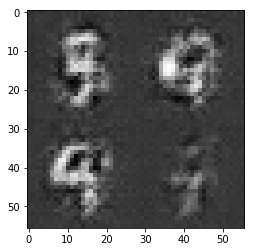

Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.3963
Epoch 1/2... Discriminator Loss: 1.5869... Generator Loss: 0.2804
Epoch 1/2... Discriminator Loss: 0.4434... Generator Loss: 1.3374
Epoch 1/2... Discriminator Loss: 0.9663... Generator Loss: 0.6957
Epoch 1/2... Discriminator Loss: 0.4014... Generator Loss: 1.5592
Epoch 1/2... Discriminator Loss: 0.5030... Generator Loss: 3.5517
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 0.6749
Epoch 1/2... Discriminator Loss: 0.6185... Generator Loss: 1.3748
Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 0.6136
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 0.7256


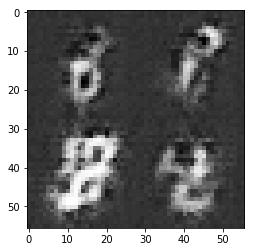

Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 0.4703
Epoch 1/2... Discriminator Loss: 0.5558... Generator Loss: 1.0879
Epoch 1/2... Discriminator Loss: 0.5092... Generator Loss: 1.2787
Epoch 1/2... Discriminator Loss: 1.5476... Generator Loss: 0.3101
Epoch 1/2... Discriminator Loss: 1.7871... Generator Loss: 0.5419
Epoch 1/2... Discriminator Loss: 2.1183... Generator Loss: 0.1861
Epoch 1/2... Discriminator Loss: 0.6704... Generator Loss: 1.1240
Epoch 1/2... Discriminator Loss: 1.1810... Generator Loss: 0.8014
Epoch 1/2... Discriminator Loss: 1.7878... Generator Loss: 0.5247
Epoch 1/2... Discriminator Loss: 2.0867... Generator Loss: 0.2310


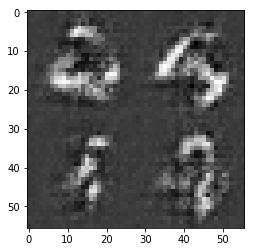

Epoch 1/2... Discriminator Loss: 0.5171... Generator Loss: 1.3411
Epoch 1/2... Discriminator Loss: 2.2674... Generator Loss: 0.1157
Epoch 1/2... Discriminator Loss: 0.8294... Generator Loss: 0.8112
Epoch 1/2... Discriminator Loss: 0.4077... Generator Loss: 1.6404
Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 0.4031
Epoch 1/2... Discriminator Loss: 1.7772... Generator Loss: 0.2198
Epoch 1/2... Discriminator Loss: 2.8729... Generator Loss: 0.0752
Epoch 1/2... Discriminator Loss: 0.5915... Generator Loss: 0.9991
Epoch 1/2... Discriminator Loss: 0.3885... Generator Loss: 1.2617
Epoch 1/2... Discriminator Loss: 0.8302... Generator Loss: 0.7898


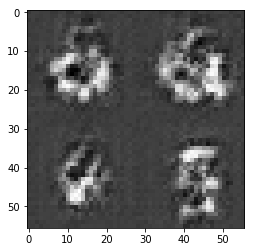

Epoch 1/2... Discriminator Loss: 0.8016... Generator Loss: 0.7737
Epoch 1/2... Discriminator Loss: 0.5264... Generator Loss: 1.3763
Epoch 1/2... Discriminator Loss: 0.9178... Generator Loss: 0.5603
Epoch 1/2... Discriminator Loss: 0.7745... Generator Loss: 0.8724
Epoch 1/2... Discriminator Loss: 0.5701... Generator Loss: 1.3047
Epoch 1/2... Discriminator Loss: 0.6568... Generator Loss: 1.0400
Epoch 1/2... Discriminator Loss: 1.8978... Generator Loss: 0.1965
Epoch 1/2... Discriminator Loss: 0.6810... Generator Loss: 1.0152
Epoch 1/2... Discriminator Loss: 1.0391... Generator Loss: 0.5441
Epoch 1/2... Discriminator Loss: 0.8742... Generator Loss: 0.8733


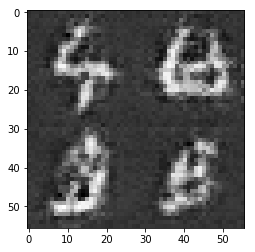

Epoch 1/2... Discriminator Loss: 1.7042... Generator Loss: 0.3263
Epoch 1/2... Discriminator Loss: 0.4130... Generator Loss: 1.6380
Epoch 1/2... Discriminator Loss: 1.4361... Generator Loss: 1.9847
Epoch 1/2... Discriminator Loss: 1.8745... Generator Loss: 0.3353
Epoch 1/2... Discriminator Loss: 0.4757... Generator Loss: 1.3296
Epoch 1/2... Discriminator Loss: 2.1941... Generator Loss: 0.1959
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 0.7874
Epoch 1/2... Discriminator Loss: 0.4442... Generator Loss: 1.2608
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 0.5545
Epoch 1/2... Discriminator Loss: 0.3376... Generator Loss: 1.5838


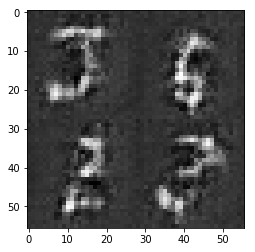

Epoch 1/2... Discriminator Loss: 0.0782... Generator Loss: 3.7192
Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 0.8078
Epoch 1/2... Discriminator Loss: 0.1066... Generator Loss: 3.3866
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 0.9119
Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 0.6727
Epoch 1/2... Discriminator Loss: 0.0877... Generator Loss: 2.8731
Epoch 1/2... Discriminator Loss: 0.3183... Generator Loss: 1.5201
Epoch 1/2... Discriminator Loss: 0.1029... Generator Loss: 3.8847
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 1.0507... Generator Loss: 0.6337


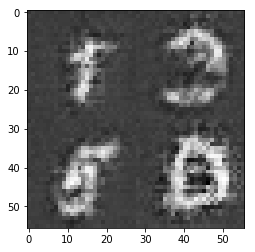

Epoch 1/2... Discriminator Loss: 0.6935... Generator Loss: 1.1998
Epoch 1/2... Discriminator Loss: 0.6819... Generator Loss: 0.9567
Epoch 1/2... Discriminator Loss: 0.2780... Generator Loss: 1.9086
Epoch 1/2... Discriminator Loss: 0.7639... Generator Loss: 0.9158
Epoch 1/2... Discriminator Loss: 0.2894... Generator Loss: 1.5970
Epoch 1/2... Discriminator Loss: 0.4787... Generator Loss: 1.3004
Epoch 1/2... Discriminator Loss: 0.3090... Generator Loss: 2.8071
Epoch 1/2... Discriminator Loss: 0.1810... Generator Loss: 4.3882
Epoch 1/2... Discriminator Loss: 2.8837... Generator Loss: 0.0771
Epoch 1/2... Discriminator Loss: 0.7318... Generator Loss: 1.2870


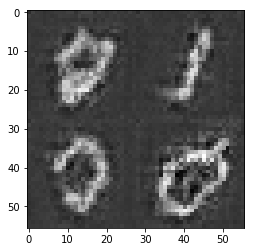

Epoch 1/2... Discriminator Loss: 0.7801... Generator Loss: 1.1374
Epoch 1/2... Discriminator Loss: 0.3441... Generator Loss: 1.3783
Epoch 1/2... Discriminator Loss: 0.4053... Generator Loss: 1.2338
Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 0.7322
Epoch 1/2... Discriminator Loss: 0.3435... Generator Loss: 3.5841
Epoch 1/2... Discriminator Loss: 0.5115... Generator Loss: 1.1425
Epoch 1/2... Discriminator Loss: 0.1629... Generator Loss: 2.8166
Epoch 1/2... Discriminator Loss: 0.8980... Generator Loss: 0.6854
Epoch 1/2... Discriminator Loss: 0.1125... Generator Loss: 3.1648
Epoch 1/2... Discriminator Loss: 0.1922... Generator Loss: 1.9733


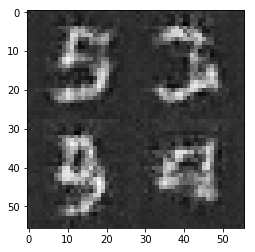

Epoch 1/2... Discriminator Loss: 0.0701... Generator Loss: 3.3255
Epoch 1/2... Discriminator Loss: 2.0528... Generator Loss: 0.2813
Epoch 1/2... Discriminator Loss: 0.1540... Generator Loss: 2.6064
Epoch 1/2... Discriminator Loss: 3.3310... Generator Loss: 0.0411
Epoch 1/2... Discriminator Loss: 0.4901... Generator Loss: 1.3295
Epoch 1/2... Discriminator Loss: 0.1535... Generator Loss: 2.9650
Epoch 1/2... Discriminator Loss: 0.3578... Generator Loss: 2.2029
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 0.6161
Epoch 1/2... Discriminator Loss: 1.7073... Generator Loss: 0.2580
Epoch 1/2... Discriminator Loss: 0.1619... Generator Loss: 4.2722


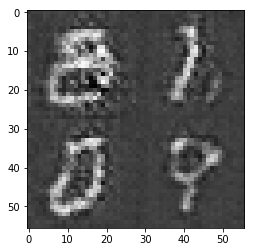

Epoch 1/2... Discriminator Loss: 0.3221... Generator Loss: 1.7054
Epoch 1/2... Discriminator Loss: 0.8646... Generator Loss: 0.6601
Epoch 1/2... Discriminator Loss: 0.3531... Generator Loss: 1.5761
Epoch 1/2... Discriminator Loss: 0.6192... Generator Loss: 0.9912
Epoch 1/2... Discriminator Loss: 0.1797... Generator Loss: 2.3220
Epoch 1/2... Discriminator Loss: 0.2508... Generator Loss: 2.0172
Epoch 1/2... Discriminator Loss: 2.7600... Generator Loss: 0.1198
Epoch 1/2... Discriminator Loss: 0.2635... Generator Loss: 2.1294
Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 0.5667
Epoch 1/2... Discriminator Loss: 0.5482... Generator Loss: 1.2528


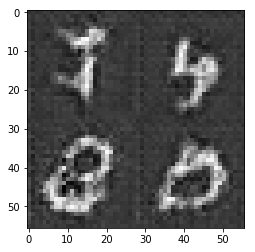

Epoch 1/2... Discriminator Loss: 0.5146... Generator Loss: 1.0454
Epoch 1/2... Discriminator Loss: 0.3924... Generator Loss: 1.4359
Epoch 1/2... Discriminator Loss: 0.2208... Generator Loss: 2.0400
Epoch 1/2... Discriminator Loss: 0.5959... Generator Loss: 1.3542
Epoch 1/2... Discriminator Loss: 3.0668... Generator Loss: 0.0571
Epoch 1/2... Discriminator Loss: 0.1075... Generator Loss: 3.6824
Epoch 1/2... Discriminator Loss: 0.5087... Generator Loss: 1.3728
Epoch 1/2... Discriminator Loss: 0.3686... Generator Loss: 1.9189
Epoch 1/2... Discriminator Loss: 0.6407... Generator Loss: 0.9446
Epoch 1/2... Discriminator Loss: 0.7950... Generator Loss: 0.7342


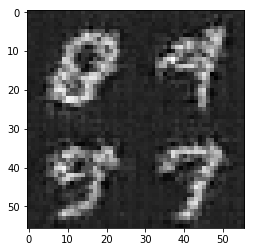

Epoch 1/2... Discriminator Loss: 0.6781... Generator Loss: 1.1059
Epoch 1/2... Discriminator Loss: 0.3432... Generator Loss: 1.6174
Epoch 1/2... Discriminator Loss: 0.1293... Generator Loss: 2.4343
Epoch 1/2... Discriminator Loss: 1.7100... Generator Loss: 0.2593
Epoch 1/2... Discriminator Loss: 0.4871... Generator Loss: 1.3965
Epoch 1/2... Discriminator Loss: 0.6751... Generator Loss: 1.0373
Epoch 1/2... Discriminator Loss: 0.2086... Generator Loss: 2.0245
Epoch 1/2... Discriminator Loss: 0.4287... Generator Loss: 1.7476
Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 1.0904
Epoch 1/2... Discriminator Loss: 0.3127... Generator Loss: 2.7112


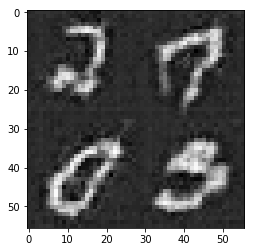

Epoch 1/2... Discriminator Loss: 0.0161... Generator Loss: 5.7990
Epoch 1/2... Discriminator Loss: 0.5368... Generator Loss: 1.1506
Epoch 1/2... Discriminator Loss: 0.1705... Generator Loss: 2.2903
Epoch 1/2... Discriminator Loss: 0.0668... Generator Loss: 3.9119
Epoch 1/2... Discriminator Loss: 0.0230... Generator Loss: 4.9111
Epoch 1/2... Discriminator Loss: 0.1746... Generator Loss: 2.5911
Epoch 1/2... Discriminator Loss: 0.0138... Generator Loss: 6.3571
Epoch 1/2... Discriminator Loss: 0.8900... Generator Loss: 0.7924
Epoch 1/2... Discriminator Loss: 0.6387... Generator Loss: 1.3041
Epoch 1/2... Discriminator Loss: 0.1998... Generator Loss: 2.1122


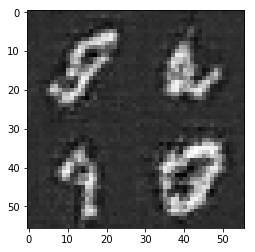

Epoch 1/2... Discriminator Loss: 0.0798... Generator Loss: 3.3362
Epoch 1/2... Discriminator Loss: 0.0220... Generator Loss: 4.7731
Epoch 1/2... Discriminator Loss: 0.0791... Generator Loss: 3.1077
Epoch 1/2... Discriminator Loss: 0.3811... Generator Loss: 1.4744
Epoch 1/2... Discriminator Loss: 0.4588... Generator Loss: 1.3235
Epoch 1/2... Discriminator Loss: 0.1570... Generator Loss: 2.4535
Epoch 1/2... Discriminator Loss: 0.6245... Generator Loss: 1.1752
Epoch 1/2... Discriminator Loss: 0.9114... Generator Loss: 1.0531
Epoch 1/2... Discriminator Loss: 0.2103... Generator Loss: 2.2443
Epoch 1/2... Discriminator Loss: 0.3896... Generator Loss: 1.8066


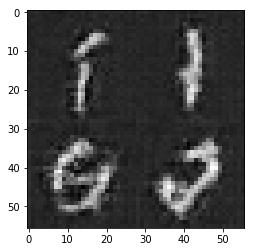

Epoch 1/2... Discriminator Loss: 0.6139... Generator Loss: 2.9340
Epoch 1/2... Discriminator Loss: 0.3632... Generator Loss: 2.1056
Epoch 1/2... Discriminator Loss: 0.6052... Generator Loss: 1.0167
Epoch 1/2... Discriminator Loss: 0.4150... Generator Loss: 1.8508
Epoch 1/2... Discriminator Loss: 0.5583... Generator Loss: 1.0709
Epoch 1/2... Discriminator Loss: 0.9470... Generator Loss: 0.6810
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 0.6560
Epoch 1/2... Discriminator Loss: 0.4328... Generator Loss: 1.3355
Epoch 1/2... Discriminator Loss: 0.6997... Generator Loss: 1.0967
Epoch 1/2... Discriminator Loss: 0.6144... Generator Loss: 1.1054


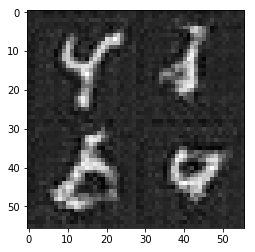

Epoch 1/2... Discriminator Loss: 0.2600... Generator Loss: 1.8940
Epoch 1/2... Discriminator Loss: 0.2010... Generator Loss: 2.2035
Epoch 1/2... Discriminator Loss: 0.5256... Generator Loss: 1.3382
Epoch 1/2... Discriminator Loss: 0.4722... Generator Loss: 1.3505
Epoch 1/2... Discriminator Loss: 0.5079... Generator Loss: 1.1162
Epoch 1/2... Discriminator Loss: 0.1631... Generator Loss: 2.1783
Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 0.6664
Epoch 1/2... Discriminator Loss: 0.2999... Generator Loss: 2.9325
Epoch 1/2... Discriminator Loss: 0.3645... Generator Loss: 1.6808
Epoch 1/2... Discriminator Loss: 1.8906... Generator Loss: 0.2155


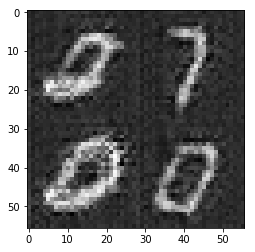

Epoch 1/2... Discriminator Loss: 1.5649... Generator Loss: 0.3217
Epoch 1/2... Discriminator Loss: 0.8136... Generator Loss: 0.9015
Epoch 1/2... Discriminator Loss: 0.8120... Generator Loss: 0.7156
Epoch 1/2... Discriminator Loss: 0.1094... Generator Loss: 2.7993
Epoch 1/2... Discriminator Loss: 0.4240... Generator Loss: 1.2340
Epoch 1/2... Discriminator Loss: 0.5193... Generator Loss: 1.3206
Epoch 1/2... Discriminator Loss: 0.8665... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 0.2590... Generator Loss: 2.1173
Epoch 1/2... Discriminator Loss: 0.2514... Generator Loss: 1.9473
Epoch 1/2... Discriminator Loss: 0.2108... Generator Loss: 2.2313


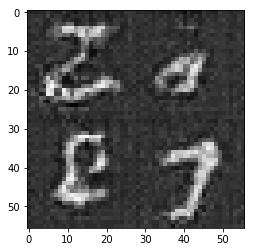

Epoch 1/2... Discriminator Loss: 0.6560... Generator Loss: 1.1435
Epoch 1/2... Discriminator Loss: 0.6959... Generator Loss: 0.7375
Epoch 1/2... Discriminator Loss: 0.5695... Generator Loss: 1.0858
Epoch 1/2... Discriminator Loss: 0.1820... Generator Loss: 2.2770
Epoch 1/2... Discriminator Loss: 0.2053... Generator Loss: 2.2132
Epoch 1/2... Discriminator Loss: 0.3530... Generator Loss: 2.1941
Epoch 1/2... Discriminator Loss: 1.0506... Generator Loss: 0.5047
Epoch 1/2... Discriminator Loss: 0.6108... Generator Loss: 0.9661
Epoch 1/2... Discriminator Loss: 0.3995... Generator Loss: 1.2760
Epoch 1/2... Discriminator Loss: 0.1200... Generator Loss: 2.8165


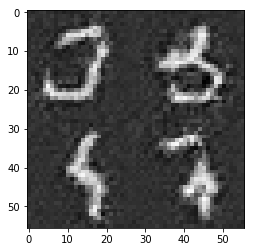

Epoch 1/2... Discriminator Loss: 0.0280... Generator Loss: 5.4608
Epoch 1/2... Discriminator Loss: 0.3082... Generator Loss: 1.7078
Epoch 1/2... Discriminator Loss: 0.3957... Generator Loss: 1.5879
Epoch 1/2... Discriminator Loss: 0.1497... Generator Loss: 2.2674
Epoch 1/2... Discriminator Loss: 0.0696... Generator Loss: 3.4934
Epoch 1/2... Discriminator Loss: 0.2208... Generator Loss: 2.1410
Epoch 1/2... Discriminator Loss: 0.1510... Generator Loss: 2.4666
Epoch 1/2... Discriminator Loss: 1.1043... Generator Loss: 0.5276
Epoch 1/2... Discriminator Loss: 0.0537... Generator Loss: 3.3979
Epoch 1/2... Discriminator Loss: 1.3153... Generator Loss: 0.6184


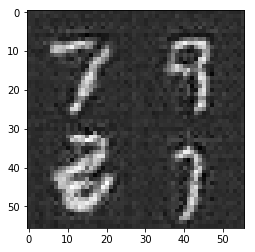

Epoch 1/2... Discriminator Loss: 1.7749... Generator Loss: 0.3094
Epoch 1/2... Discriminator Loss: 0.8765... Generator Loss: 0.5680
Epoch 1/2... Discriminator Loss: 0.6092... Generator Loss: 1.2460
Epoch 1/2... Discriminator Loss: 0.2457... Generator Loss: 1.9605
Epoch 1/2... Discriminator Loss: 0.0909... Generator Loss: 2.7297
Epoch 1/2... Discriminator Loss: 0.0408... Generator Loss: 3.5176
Epoch 1/2... Discriminator Loss: 0.0569... Generator Loss: 3.4740
Epoch 1/2... Discriminator Loss: 0.2814... Generator Loss: 1.6917
Epoch 1/2... Discriminator Loss: 3.1680... Generator Loss: 1.3382
Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 0.5833


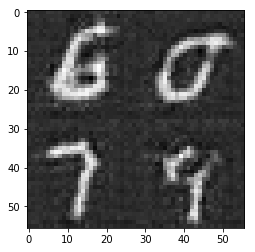

Epoch 1/2... Discriminator Loss: 0.8158... Generator Loss: 0.8922
Epoch 1/2... Discriminator Loss: 0.6629... Generator Loss: 1.0198
Epoch 1/2... Discriminator Loss: 0.4384... Generator Loss: 1.3592
Epoch 1/2... Discriminator Loss: 0.3204... Generator Loss: 1.8268
Epoch 1/2... Discriminator Loss: 1.7583... Generator Loss: 0.2816
Epoch 1/2... Discriminator Loss: 1.1194... Generator Loss: 0.6087
Epoch 1/2... Discriminator Loss: 0.0196... Generator Loss: 4.2201
Epoch 1/2... Discriminator Loss: 0.0172... Generator Loss: 7.1539
Epoch 1/2... Discriminator Loss: 0.1115... Generator Loss: 2.9622
Epoch 1/2... Discriminator Loss: 0.3808... Generator Loss: 1.3650


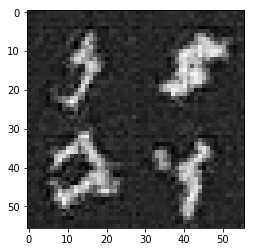

Epoch 1/2... Discriminator Loss: 0.2837... Generator Loss: 1.7338
Epoch 1/2... Discriminator Loss: 0.7393... Generator Loss: 1.2963
Epoch 1/2... Discriminator Loss: 0.7262... Generator Loss: 1.2790
Epoch 1/2... Discriminator Loss: 0.6568... Generator Loss: 1.1021
Epoch 1/2... Discriminator Loss: 0.0092... Generator Loss: 5.3565
Epoch 1/2... Discriminator Loss: 0.0760... Generator Loss: 3.6083
Epoch 1/2... Discriminator Loss: 1.8827... Generator Loss: 0.3152
Epoch 1/2... Discriminator Loss: 0.3573... Generator Loss: 2.0197
Epoch 1/2... Discriminator Loss: 0.0307... Generator Loss: 4.4475
Epoch 1/2... Discriminator Loss: 0.2705... Generator Loss: 1.9790


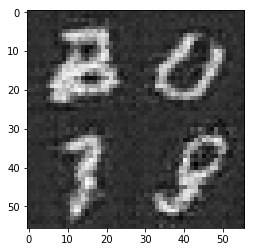

Epoch 1/2... Discriminator Loss: 0.0276... Generator Loss: 4.6555
Epoch 1/2... Discriminator Loss: 0.0194... Generator Loss: 4.2528
Epoch 1/2... Discriminator Loss: 0.1836... Generator Loss: 2.1638
Epoch 1/2... Discriminator Loss: 1.8586... Generator Loss: 0.2212
Epoch 1/2... Discriminator Loss: 0.7238... Generator Loss: 0.9623
Epoch 1/2... Discriminator Loss: 0.5334... Generator Loss: 1.4763
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 0.5494
Epoch 1/2... Discriminator Loss: 0.4031... Generator Loss: 2.0137
Epoch 1/2... Discriminator Loss: 0.1983... Generator Loss: 2.0758
Epoch 1/2... Discriminator Loss: 0.1003... Generator Loss: 3.0706


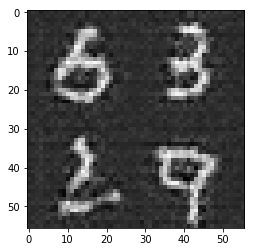

Epoch 1/2... Discriminator Loss: 0.1114... Generator Loss: 3.0229
Epoch 1/2... Discriminator Loss: 0.1790... Generator Loss: 2.3463
Epoch 1/2... Discriminator Loss: 2.1661... Generator Loss: 0.2182
Epoch 1/2... Discriminator Loss: 0.0239... Generator Loss: 5.0165
Epoch 1/2... Discriminator Loss: 9.8126... Generator Loss: 10.7297
Epoch 1/2... Discriminator Loss: 0.5372... Generator Loss: 1.1038
Epoch 1/2... Discriminator Loss: 0.2553... Generator Loss: 2.4249
Epoch 1/2... Discriminator Loss: 0.1019... Generator Loss: 4.2727
Epoch 1/2... Discriminator Loss: 0.3411... Generator Loss: 1.7758
Epoch 1/2... Discriminator Loss: 0.2347... Generator Loss: 2.0548


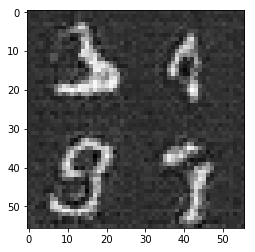

Epoch 1/2... Discriminator Loss: 0.0760... Generator Loss: 4.6178
Epoch 1/2... Discriminator Loss: 0.2708... Generator Loss: 1.7936
Epoch 1/2... Discriminator Loss: 0.2194... Generator Loss: 1.9284
Epoch 1/2... Discriminator Loss: 0.1217... Generator Loss: 2.9891
Epoch 1/2... Discriminator Loss: 0.2399... Generator Loss: 2.0962
Epoch 1/2... Discriminator Loss: 0.3784... Generator Loss: 1.8333
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 0.8054
Epoch 1/2... Discriminator Loss: 0.7078... Generator Loss: 0.9124
Epoch 1/2... Discriminator Loss: 1.4987... Generator Loss: 0.3079
Epoch 1/2... Discriminator Loss: 0.3964... Generator Loss: 1.2701


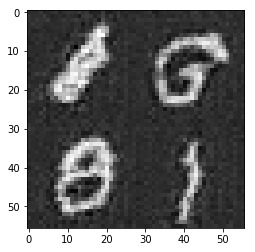

Epoch 1/2... Discriminator Loss: 0.6066... Generator Loss: 1.2579
Epoch 1/2... Discriminator Loss: 0.1196... Generator Loss: 2.6564
Epoch 1/2... Discriminator Loss: 0.0848... Generator Loss: 2.9689
Epoch 1/2... Discriminator Loss: 0.6307... Generator Loss: 0.9861
Epoch 1/2... Discriminator Loss: 0.1469... Generator Loss: 2.6952
Epoch 1/2... Discriminator Loss: 0.1289... Generator Loss: 2.2612
Epoch 1/2... Discriminator Loss: 0.0102... Generator Loss: 7.2167
Epoch 1/2... Discriminator Loss: 0.1959... Generator Loss: 3.4818
Epoch 1/2... Discriminator Loss: 0.5545... Generator Loss: 1.0392
Epoch 1/2... Discriminator Loss: 0.2089... Generator Loss: 2.3515


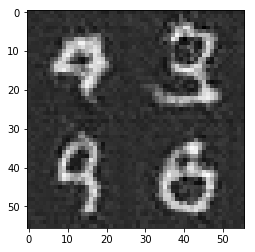

Epoch 1/2... Discriminator Loss: 0.6068... Generator Loss: 0.9501
Epoch 1/2... Discriminator Loss: 0.2554... Generator Loss: 6.1869
Epoch 1/2... Discriminator Loss: 0.8073... Generator Loss: 0.7280
Epoch 1/2... Discriminator Loss: 0.1128... Generator Loss: 2.6481
Epoch 1/2... Discriminator Loss: 0.7581... Generator Loss: 1.3002
Epoch 1/2... Discriminator Loss: 0.0423... Generator Loss: 4.5976
Epoch 1/2... Discriminator Loss: 0.0830... Generator Loss: 3.4083
Epoch 1/2... Discriminator Loss: 0.5693... Generator Loss: 0.9770
Epoch 1/2... Discriminator Loss: 1.7234... Generator Loss: 0.3256
Epoch 1/2... Discriminator Loss: 0.5243... Generator Loss: 1.3661


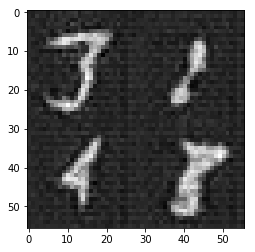

Epoch 1/2... Discriminator Loss: 0.2255... Generator Loss: 5.6096
Epoch 1/2... Discriminator Loss: 0.5395... Generator Loss: 1.3651
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 0.6568
Epoch 1/2... Discriminator Loss: 0.1851... Generator Loss: 2.0303
Epoch 1/2... Discriminator Loss: 0.1543... Generator Loss: 2.5188
Epoch 1/2... Discriminator Loss: 0.1238... Generator Loss: 3.4385
Epoch 1/2... Discriminator Loss: 0.8004... Generator Loss: 1.0309
Epoch 1/2... Discriminator Loss: 0.2276... Generator Loss: 2.2169
Epoch 1/2... Discriminator Loss: 0.2905... Generator Loss: 1.9585
Epoch 1/2... Discriminator Loss: 0.1479... Generator Loss: 2.5422


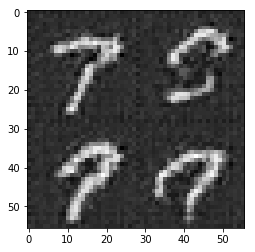

Epoch 1/2... Discriminator Loss: 1.2724... Generator Loss: 0.7130
Epoch 1/2... Discriminator Loss: 0.9879... Generator Loss: 0.6455
Epoch 1/2... Discriminator Loss: 0.2879... Generator Loss: 1.6520
Epoch 1/2... Discriminator Loss: 0.1134... Generator Loss: 2.6739
Epoch 1/2... Discriminator Loss: 0.2073... Generator Loss: 2.6238
Epoch 1/2... Discriminator Loss: 0.2109... Generator Loss: 2.3802
Epoch 1/2... Discriminator Loss: 0.4031... Generator Loss: 1.7058
Epoch 1/2... Discriminator Loss: 0.0436... Generator Loss: 3.6521
Epoch 1/2... Discriminator Loss: 0.1767... Generator Loss: 2.8118
Epoch 1/2... Discriminator Loss: 0.0235... Generator Loss: 4.8148


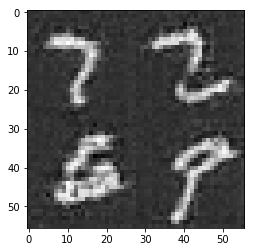

Epoch 1/2... Discriminator Loss: 0.4237... Generator Loss: 1.4093
Epoch 1/2... Discriminator Loss: 0.5832... Generator Loss: 1.1423
Epoch 1/2... Discriminator Loss: 0.4020... Generator Loss: 1.7463
Epoch 1/2... Discriminator Loss: 0.0354... Generator Loss: 4.2645
Epoch 1/2... Discriminator Loss: 0.2731... Generator Loss: 2.0636
Epoch 1/2... Discriminator Loss: 0.2788... Generator Loss: 1.7379
Epoch 1/2... Discriminator Loss: 0.0460... Generator Loss: 3.5258
Epoch 1/2... Discriminator Loss: 0.4249... Generator Loss: 1.3940
Epoch 1/2... Discriminator Loss: 0.0778... Generator Loss: 3.1064
Epoch 1/2... Discriminator Loss: 0.0259... Generator Loss: 4.7258


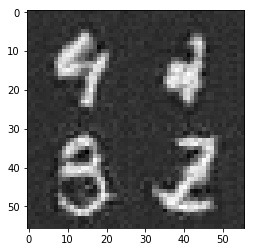

Epoch 1/2... Discriminator Loss: 2.1098... Generator Loss: 0.1966
Epoch 1/2... Discriminator Loss: 0.5676... Generator Loss: 1.3076
Epoch 1/2... Discriminator Loss: 0.2200... Generator Loss: 2.9185
Epoch 1/2... Discriminator Loss: 0.2046... Generator Loss: 2.1880
Epoch 1/2... Discriminator Loss: 0.0131... Generator Loss: 5.2296
Epoch 1/2... Discriminator Loss: 0.1490... Generator Loss: 2.4364
Epoch 1/2... Discriminator Loss: 0.3900... Generator Loss: 2.0745
Epoch 1/2... Discriminator Loss: 0.0741... Generator Loss: 5.1490
Epoch 1/2... Discriminator Loss: 0.2168... Generator Loss: 2.1141
Epoch 1/2... Discriminator Loss: 0.1519... Generator Loss: 3.1055


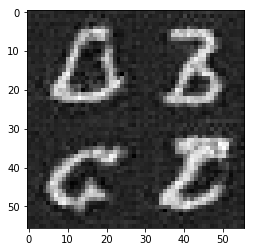

Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 0.7604
Epoch 1/2... Discriminator Loss: 0.0476... Generator Loss: 3.9408
Epoch 1/2... Discriminator Loss: 0.5317... Generator Loss: 1.4206
Epoch 1/2... Discriminator Loss: 0.2882... Generator Loss: 1.7492
Epoch 1/2... Discriminator Loss: 0.7415... Generator Loss: 0.8296
Epoch 1/2... Discriminator Loss: 0.5236... Generator Loss: 1.2487
Epoch 1/2... Discriminator Loss: 0.5772... Generator Loss: 1.0530
Epoch 1/2... Discriminator Loss: 0.5592... Generator Loss: 1.1575
Epoch 1/2... Discriminator Loss: 0.0926... Generator Loss: 3.7593
Epoch 1/2... Discriminator Loss: 0.2750... Generator Loss: 1.8037


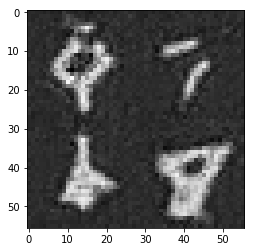

Epoch 1/2... Discriminator Loss: 0.7629... Generator Loss: 0.8557
Epoch 1/2... Discriminator Loss: 0.0432... Generator Loss: 4.5136
Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 0.4689
Epoch 1/2... Discriminator Loss: 0.0815... Generator Loss: 2.7736
Epoch 1/2... Discriminator Loss: 0.0363... Generator Loss: 4.1668
Epoch 1/2... Discriminator Loss: 0.3019... Generator Loss: 4.4460
Epoch 1/2... Discriminator Loss: 0.5488... Generator Loss: 1.3002
Epoch 1/2... Discriminator Loss: 0.3511... Generator Loss: 1.7710
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 0.8440
Epoch 1/2... Discriminator Loss: 0.8832... Generator Loss: 0.6042


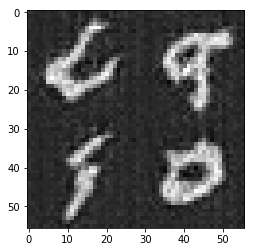

Epoch 1/2... Discriminator Loss: 0.0708... Generator Loss: 3.0198
Epoch 1/2... Discriminator Loss: 0.1886... Generator Loss: 2.1718
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 0.7172
Epoch 1/2... Discriminator Loss: 1.3099... Generator Loss: 0.4735
Epoch 1/2... Discriminator Loss: 0.8373... Generator Loss: 0.9097
Epoch 1/2... Discriminator Loss: 0.5990... Generator Loss: 1.2540
Epoch 1/2... Discriminator Loss: 0.2446... Generator Loss: 1.7268
Epoch 1/2... Discriminator Loss: 0.2281... Generator Loss: 2.0943
Epoch 1/2... Discriminator Loss: 0.5296... Generator Loss: 1.5797
Epoch 1/2... Discriminator Loss: 0.2910... Generator Loss: 1.5551


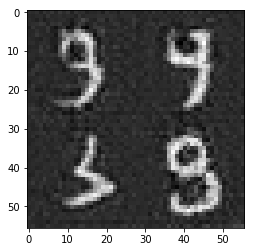

Epoch 1/2... Discriminator Loss: 0.4192... Generator Loss: 1.3875
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.4641
Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 0.3928
Epoch 1/2... Discriminator Loss: 0.0619... Generator Loss: 3.3284
Epoch 1/2... Discriminator Loss: 0.0450... Generator Loss: 5.5250
Epoch 1/2... Discriminator Loss: 0.0388... Generator Loss: 3.8089
Epoch 1/2... Discriminator Loss: 0.3795... Generator Loss: 1.4456
Epoch 1/2... Discriminator Loss: 0.1130... Generator Loss: 3.0816
Epoch 1/2... Discriminator Loss: 0.2067... Generator Loss: 2.0643
Epoch 1/2... Discriminator Loss: 0.7224... Generator Loss: 0.8314


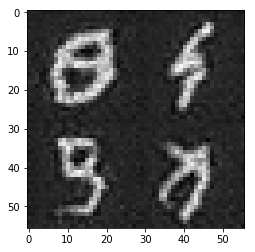

Epoch 1/2... Discriminator Loss: 0.4582... Generator Loss: 1.1313
Epoch 1/2... Discriminator Loss: 0.2412... Generator Loss: 2.0734
Epoch 1/2... Discriminator Loss: 0.0335... Generator Loss: 4.0862
Epoch 1/2... Discriminator Loss: 0.4559... Generator Loss: 1.6970
Epoch 1/2... Discriminator Loss: 0.0004... Generator Loss: 10.2582
Epoch 1/2... Discriminator Loss: 0.3030... Generator Loss: 1.7177
Epoch 1/2... Discriminator Loss: 0.1278... Generator Loss: 2.4265
Epoch 1/2... Discriminator Loss: 0.4435... Generator Loss: 1.5680
Epoch 1/2... Discriminator Loss: 0.0124... Generator Loss: 5.6360
Epoch 1/2... Discriminator Loss: 0.1383... Generator Loss: 2.2665


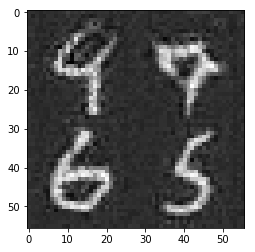

Epoch 1/2... Discriminator Loss: 0.4339... Generator Loss: 1.2952
Epoch 1/2... Discriminator Loss: 0.4935... Generator Loss: 1.6949
Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 0.6160
Epoch 1/2... Discriminator Loss: 0.3828... Generator Loss: 1.4730
Epoch 1/2... Discriminator Loss: 0.6044... Generator Loss: 1.2145
Epoch 1/2... Discriminator Loss: 0.5119... Generator Loss: 1.2559
Epoch 1/2... Discriminator Loss: 0.0318... Generator Loss: 4.7519
Epoch 1/2... Discriminator Loss: 0.8108... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 0.1835... Generator Loss: 3.2879
Epoch 1/2... Discriminator Loss: 0.7886... Generator Loss: 1.1700


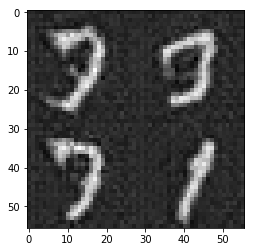

Epoch 1/2... Discriminator Loss: 0.6430... Generator Loss: 1.2019
Epoch 1/2... Discriminator Loss: 0.5443... Generator Loss: 1.9312
Epoch 1/2... Discriminator Loss: 0.0744... Generator Loss: 3.2813
Epoch 1/2... Discriminator Loss: 0.5514... Generator Loss: 1.5753
Epoch 1/2... Discriminator Loss: 0.2769... Generator Loss: 1.8777
Epoch 1/2... Discriminator Loss: 0.9362... Generator Loss: 0.6542
Epoch 1/2... Discriminator Loss: 1.6977... Generator Loss: 0.3610
Epoch 1/2... Discriminator Loss: 1.6977... Generator Loss: 0.2835
Epoch 1/2... Discriminator Loss: 0.5547... Generator Loss: 1.2474
Epoch 1/2... Discriminator Loss: 0.0401... Generator Loss: 3.7682


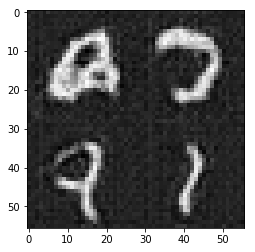

Epoch 1/2... Discriminator Loss: 0.0215... Generator Loss: 6.6720
Epoch 1/2... Discriminator Loss: 0.0246... Generator Loss: 4.5188
Epoch 1/2... Discriminator Loss: 0.3485... Generator Loss: 1.4159
Epoch 1/2... Discriminator Loss: 0.0550... Generator Loss: 3.7000
Epoch 1/2... Discriminator Loss: 0.0160... Generator Loss: 5.6113
Epoch 1/2... Discriminator Loss: 0.3306... Generator Loss: 1.4527
Epoch 1/2... Discriminator Loss: 0.2534... Generator Loss: 1.9840
Epoch 1/2... Discriminator Loss: 0.5918... Generator Loss: 1.4465
Epoch 1/2... Discriminator Loss: 0.1908... Generator Loss: 2.0461
Epoch 1/2... Discriminator Loss: 0.4460... Generator Loss: 1.3786


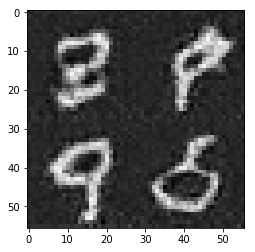

Epoch 1/2... Discriminator Loss: 0.1737... Generator Loss: 2.1584
Epoch 1/2... Discriminator Loss: 0.9303... Generator Loss: 0.9499
Epoch 1/2... Discriminator Loss: 0.0717... Generator Loss: 3.7384
Epoch 1/2... Discriminator Loss: 0.3543... Generator Loss: 1.4762
Epoch 1/2... Discriminator Loss: 0.5764... Generator Loss: 1.1987
Epoch 1/2... Discriminator Loss: 0.0957... Generator Loss: 3.0439
Epoch 1/2... Discriminator Loss: 10.6741... Generator Loss: 17.7004
Epoch 1/2... Discriminator Loss: 0.3241... Generator Loss: 1.5091
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 0.2152... Generator Loss: 2.1816


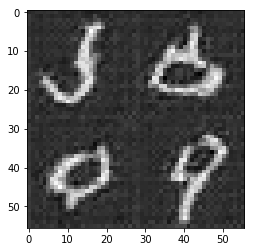

Epoch 1/2... Discriminator Loss: 0.1469... Generator Loss: 2.1601
Epoch 1/2... Discriminator Loss: 1.1580... Generator Loss: 0.4671
Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 2.2682
Epoch 1/2... Discriminator Loss: 3.3251... Generator Loss: 0.0475
Epoch 1/2... Discriminator Loss: 0.3281... Generator Loss: 2.1970
Epoch 1/2... Discriminator Loss: 0.4069... Generator Loss: 1.7006
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 0.4863
Epoch 1/2... Discriminator Loss: 0.6731... Generator Loss: 0.9241
Epoch 1/2... Discriminator Loss: 0.3393... Generator Loss: 1.9676
Epoch 1/2... Discriminator Loss: 1.7809... Generator Loss: 0.2732


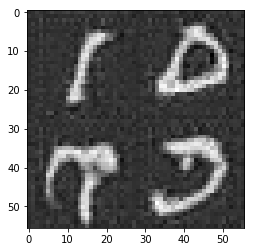

Epoch 1/2... Discriminator Loss: 0.4871... Generator Loss: 1.1315
Epoch 1/2... Discriminator Loss: 0.3312... Generator Loss: 1.5013
Epoch 1/2... Discriminator Loss: 0.1609... Generator Loss: 4.5308
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 0.7413
Epoch 1/2... Discriminator Loss: 1.1365... Generator Loss: 0.4767
Epoch 1/2... Discriminator Loss: 0.2890... Generator Loss: 2.4500
Epoch 1/2... Discriminator Loss: 0.2390... Generator Loss: 1.7443
Epoch 1/2... Discriminator Loss: 0.4034... Generator Loss: 2.7955
Epoch 1/2... Discriminator Loss: 0.5282... Generator Loss: 1.6140
Epoch 1/2... Discriminator Loss: 0.1501... Generator Loss: 2.3182


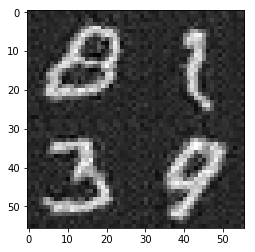

Epoch 1/2... Discriminator Loss: 0.3299... Generator Loss: 1.4602
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 0.9366
Epoch 1/2... Discriminator Loss: 0.1845... Generator Loss: 2.3577
Epoch 1/2... Discriminator Loss: 0.3659... Generator Loss: 1.4540
Epoch 1/2... Discriminator Loss: 0.1650... Generator Loss: 2.2548
Epoch 1/2... Discriminator Loss: 0.0972... Generator Loss: 2.8310
Epoch 1/2... Discriminator Loss: 0.2114... Generator Loss: 2.4619
Epoch 1/2... Discriminator Loss: 0.2662... Generator Loss: 2.0276
Epoch 1/2... Discriminator Loss: 0.3947... Generator Loss: 1.7226
Epoch 1/2... Discriminator Loss: 0.3256... Generator Loss: 1.5238


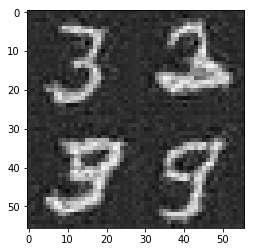

Epoch 1/2... Discriminator Loss: 1.7430... Generator Loss: 0.2186
Epoch 1/2... Discriminator Loss: 0.3556... Generator Loss: 1.5699
Epoch 1/2... Discriminator Loss: 0.6479... Generator Loss: 1.6056
Epoch 1/2... Discriminator Loss: 0.0815... Generator Loss: 3.4217
Epoch 1/2... Discriminator Loss: 0.4865... Generator Loss: 1.2325
Epoch 1/2... Discriminator Loss: 0.9370... Generator Loss: 0.6930
Epoch 1/2... Discriminator Loss: 0.3813... Generator Loss: 2.0655
Epoch 1/2... Discriminator Loss: 0.6116... Generator Loss: 1.0551
Epoch 1/2... Discriminator Loss: 0.1205... Generator Loss: 3.7308
Epoch 1/2... Discriminator Loss: 0.2008... Generator Loss: 2.3067


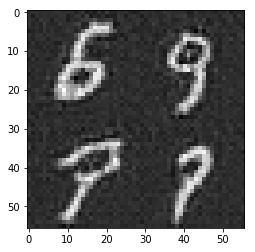

Epoch 1/2... Discriminator Loss: 0.8316... Generator Loss: 1.0552
Epoch 1/2... Discriminator Loss: 0.0270... Generator Loss: 5.2060
Epoch 1/2... Discriminator Loss: 0.0333... Generator Loss: 3.9067
Epoch 1/2... Discriminator Loss: 0.0168... Generator Loss: 5.3258
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 0.8900
Epoch 1/2... Discriminator Loss: 0.5905... Generator Loss: 6.3900
Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 0.6697
Epoch 1/2... Discriminator Loss: 0.0364... Generator Loss: 4.8535
Epoch 1/2... Discriminator Loss: 0.3549... Generator Loss: 2.2753
Epoch 1/2... Discriminator Loss: 0.0274... Generator Loss: 4.2630


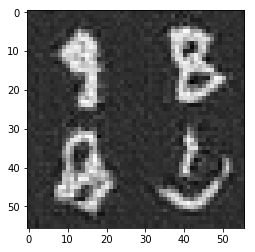

Epoch 1/2... Discriminator Loss: 0.0734... Generator Loss: 3.0829
Epoch 1/2... Discriminator Loss: 0.3408... Generator Loss: 1.3296
Epoch 1/2... Discriminator Loss: 0.1481... Generator Loss: 2.3883
Epoch 1/2... Discriminator Loss: 0.2181... Generator Loss: 2.1858
Epoch 1/2... Discriminator Loss: 0.1059... Generator Loss: 2.5909
Epoch 1/2... Discriminator Loss: 0.0150... Generator Loss: 5.8533
Epoch 1/2... Discriminator Loss: 0.0285... Generator Loss: 5.4716
Epoch 1/2... Discriminator Loss: 0.1120... Generator Loss: 2.6032
Epoch 1/2... Discriminator Loss: 0.5366... Generator Loss: 1.4890
Epoch 1/2... Discriminator Loss: 0.0996... Generator Loss: 2.5128


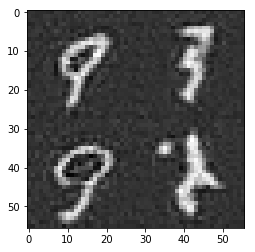

Epoch 1/2... Discriminator Loss: 0.1075... Generator Loss: 3.1554
Epoch 1/2... Discriminator Loss: 1.8064... Generator Loss: 0.2523
Epoch 1/2... Discriminator Loss: 0.6710... Generator Loss: 0.8732
Epoch 1/2... Discriminator Loss: 0.1005... Generator Loss: 2.7405
Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 0.5642
Epoch 1/2... Discriminator Loss: 0.4429... Generator Loss: 1.3539
Epoch 1/2... Discriminator Loss: 0.0189... Generator Loss: 4.7932
Epoch 1/2... Discriminator Loss: 0.2839... Generator Loss: 1.6917
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.4561
Epoch 1/2... Discriminator Loss: 0.7750... Generator Loss: 4.7425


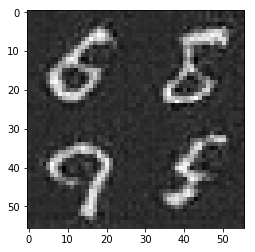

Epoch 1/2... Discriminator Loss: 0.5296... Generator Loss: 3.2704
Epoch 1/2... Discriminator Loss: 0.8066... Generator Loss: 0.7282
Epoch 1/2... Discriminator Loss: 0.3427... Generator Loss: 2.0093
Epoch 1/2... Discriminator Loss: 0.4088... Generator Loss: 1.4658
Epoch 1/2... Discriminator Loss: 0.7812... Generator Loss: 0.8388
Epoch 1/2... Discriminator Loss: 1.9484... Generator Loss: 0.3990
Epoch 1/2... Discriminator Loss: 0.2681... Generator Loss: 1.6842
Epoch 1/2... Discriminator Loss: 4.1074... Generator Loss: 0.0374
Epoch 1/2... Discriminator Loss: 0.6639... Generator Loss: 1.1380
Epoch 1/2... Discriminator Loss: 0.0631... Generator Loss: 3.1877


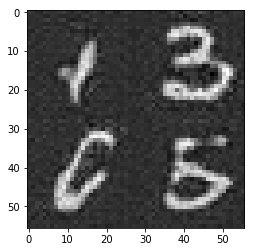

Epoch 1/2... Discriminator Loss: 1.2025... Generator Loss: 0.7296
Epoch 1/2... Discriminator Loss: 0.2937... Generator Loss: 1.6760
Epoch 1/2... Discriminator Loss: 0.0212... Generator Loss: 5.0969
Epoch 1/2... Discriminator Loss: 0.1382... Generator Loss: 2.4523
Epoch 1/2... Discriminator Loss: 0.1985... Generator Loss: 2.8873
Epoch 1/2... Discriminator Loss: 0.2890... Generator Loss: 1.7504
Epoch 1/2... Discriminator Loss: 0.0823... Generator Loss: 4.7295
Epoch 1/2... Discriminator Loss: 0.4095... Generator Loss: 1.6246
Epoch 1/2... Discriminator Loss: 1.5873... Generator Loss: 0.3968
Epoch 1/2... Discriminator Loss: 0.2071... Generator Loss: 2.3003


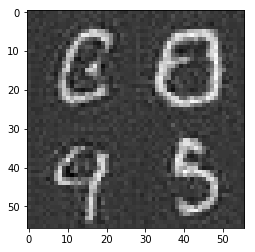

Epoch 1/2... Discriminator Loss: 0.2772... Generator Loss: 1.7645
Epoch 1/2... Discriminator Loss: 0.4070... Generator Loss: 1.5388
Epoch 1/2... Discriminator Loss: 1.0430... Generator Loss: 0.6443
Epoch 1/2... Discriminator Loss: 0.1439... Generator Loss: 3.3800
Epoch 1/2... Discriminator Loss: 1.7781... Generator Loss: 0.3890
Epoch 1/2... Discriminator Loss: 0.0132... Generator Loss: 5.4954
Epoch 1/2... Discriminator Loss: 0.2527... Generator Loss: 2.0952
Epoch 1/2... Discriminator Loss: 0.1177... Generator Loss: 2.5927
Epoch 1/2... Discriminator Loss: 0.0328... Generator Loss: 4.0978
Epoch 1/2... Discriminator Loss: 0.2379... Generator Loss: 2.2561


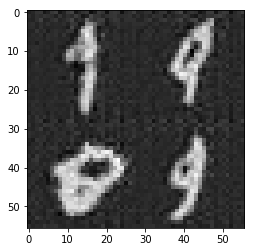

Epoch 1/2... Discriminator Loss: 0.3573... Generator Loss: 1.4944
Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 1.0886
Epoch 1/2... Discriminator Loss: 0.1034... Generator Loss: 2.9688
Epoch 1/2... Discriminator Loss: 0.0066... Generator Loss: 5.6747
Epoch 1/2... Discriminator Loss: 0.8762... Generator Loss: 1.0514
Epoch 1/2... Discriminator Loss: 0.2071... Generator Loss: 2.3818
Epoch 1/2... Discriminator Loss: 0.2652... Generator Loss: 2.3213
Epoch 1/2... Discriminator Loss: 0.6178... Generator Loss: 1.1625
Epoch 1/2... Discriminator Loss: 0.6904... Generator Loss: 0.9965
Epoch 1/2... Discriminator Loss: 1.8035... Generator Loss: 0.2485


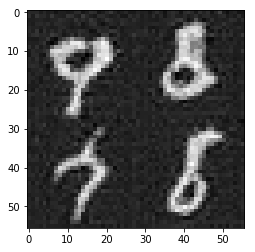

Epoch 1/2... Discriminator Loss: 0.6070... Generator Loss: 1.3831
Epoch 1/2... Discriminator Loss: 0.7097... Generator Loss: 1.0250
Epoch 1/2... Discriminator Loss: 0.9161... Generator Loss: 0.7298
Epoch 1/2... Discriminator Loss: 0.6697... Generator Loss: 0.8663
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 0.5491
Epoch 1/2... Discriminator Loss: 0.0176... Generator Loss: 4.4739
Epoch 1/2... Discriminator Loss: 0.3322... Generator Loss: 1.6295
Epoch 1/2... Discriminator Loss: 0.5048... Generator Loss: 1.5375
Epoch 1/2... Discriminator Loss: 0.0651... Generator Loss: 8.7566
Epoch 1/2... Discriminator Loss: 0.3614... Generator Loss: 1.6773


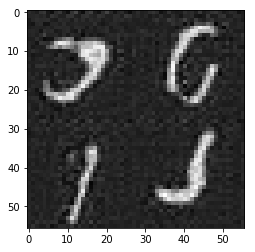

Epoch 1/2... Discriminator Loss: 0.0317... Generator Loss: 6.5932
Epoch 1/2... Discriminator Loss: 0.0882... Generator Loss: 2.7867
Epoch 1/2... Discriminator Loss: 0.0848... Generator Loss: 2.9654
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 0.9428
Epoch 1/2... Discriminator Loss: 5.2148... Generator Loss: 0.0059
Epoch 1/2... Discriminator Loss: 0.1513... Generator Loss: 4.3591
Epoch 1/2... Discriminator Loss: 0.0942... Generator Loss: 4.7499
Epoch 1/2... Discriminator Loss: 0.3742... Generator Loss: 1.7005
Epoch 1/2... Discriminator Loss: 0.1420... Generator Loss: 2.7236
Epoch 1/2... Discriminator Loss: 0.0613... Generator Loss: 3.7839


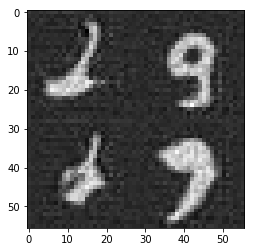

Epoch 1/2... Discriminator Loss: 0.4378... Generator Loss: 1.8115
Epoch 1/2... Discriminator Loss: 0.7514... Generator Loss: 1.0362
Epoch 1/2... Discriminator Loss: 0.5469... Generator Loss: 1.2499
Epoch 1/2... Discriminator Loss: 0.1626... Generator Loss: 2.9641
Epoch 1/2... Discriminator Loss: 0.5207... Generator Loss: 1.6814
Epoch 1/2... Discriminator Loss: 0.0426... Generator Loss: 4.1707
Epoch 1/2... Discriminator Loss: 1.9538... Generator Loss: 0.2685
Epoch 1/2... Discriminator Loss: 0.2235... Generator Loss: 2.8674
Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 1.0989
Epoch 1/2... Discriminator Loss: 0.2981... Generator Loss: 1.7086


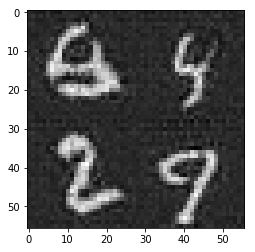

Epoch 1/2... Discriminator Loss: 0.3026... Generator Loss: 2.3711
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.4139
Epoch 1/2... Discriminator Loss: 0.1969... Generator Loss: 1.8656
Epoch 1/2... Discriminator Loss: 0.4194... Generator Loss: 1.3935
Epoch 1/2... Discriminator Loss: 0.7402... Generator Loss: 1.0498
Epoch 1/2... Discriminator Loss: 0.7730... Generator Loss: 0.9808
Epoch 1/2... Discriminator Loss: 0.8990... Generator Loss: 1.1742
Epoch 1/2... Discriminator Loss: 0.9354... Generator Loss: 0.9000
Epoch 1/2... Discriminator Loss: 0.1521... Generator Loss: 2.3111
Epoch 1/2... Discriminator Loss: 1.8759... Generator Loss: 0.2867


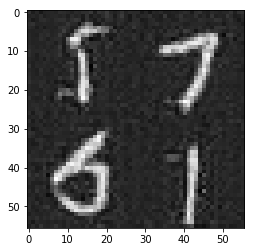

Epoch 1/2... Discriminator Loss: 0.9497... Generator Loss: 0.6912
Epoch 1/2... Discriminator Loss: 0.4392... Generator Loss: 1.4694
Epoch 1/2... Discriminator Loss: 0.4245... Generator Loss: 1.7761
Epoch 1/2... Discriminator Loss: 1.1982... Generator Loss: 0.8131
Epoch 1/2... Discriminator Loss: 3.3848... Generator Loss: 0.0570
Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 0.5286
Epoch 1/2... Discriminator Loss: 0.2747... Generator Loss: 4.5996
Epoch 1/2... Discriminator Loss: 0.4865... Generator Loss: 1.4927
Epoch 1/2... Discriminator Loss: 0.3592... Generator Loss: 1.4439
Epoch 1/2... Discriminator Loss: 0.4034... Generator Loss: 2.1115


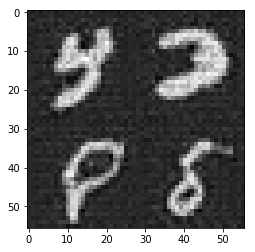

Epoch 1/2... Discriminator Loss: 0.6335... Generator Loss: 1.0234
Epoch 1/2... Discriminator Loss: 0.6786... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 0.3721... Generator Loss: 2.0147
Epoch 1/2... Discriminator Loss: 0.1584... Generator Loss: 3.3583
Epoch 1/2... Discriminator Loss: 0.2086... Generator Loss: 2.9351
Epoch 1/2... Discriminator Loss: 0.5417... Generator Loss: 1.2596
Epoch 1/2... Discriminator Loss: 0.0829... Generator Loss: 3.0338
Epoch 1/2... Discriminator Loss: 0.5643... Generator Loss: 0.9944
Epoch 1/2... Discriminator Loss: 0.7884... Generator Loss: 1.4638
Epoch 1/2... Discriminator Loss: 0.5472... Generator Loss: 1.1230


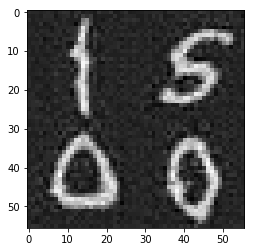

Epoch 1/2... Discriminator Loss: 0.4831... Generator Loss: 1.5812
Epoch 1/2... Discriminator Loss: 0.3716... Generator Loss: 1.6493
Epoch 1/2... Discriminator Loss: 0.0936... Generator Loss: 3.0913
Epoch 1/2... Discriminator Loss: 1.6700... Generator Loss: 0.3328
Epoch 1/2... Discriminator Loss: 0.7492... Generator Loss: 0.9913
Epoch 1/2... Discriminator Loss: 0.2646... Generator Loss: 4.8351
Epoch 1/2... Discriminator Loss: 0.5150... Generator Loss: 1.6497
Epoch 1/2... Discriminator Loss: 1.1478... Generator Loss: 0.5617
Epoch 1/2... Discriminator Loss: 0.1173... Generator Loss: 2.4675
Epoch 1/2... Discriminator Loss: 0.5090... Generator Loss: 1.2114


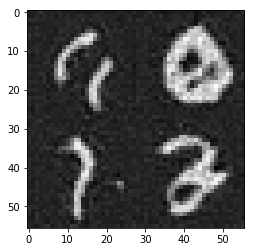

Epoch 1/2... Discriminator Loss: 0.1963... Generator Loss: 2.5128
Epoch 1/2... Discriminator Loss: 0.7083... Generator Loss: 1.2704
Epoch 1/2... Discriminator Loss: 0.0532... Generator Loss: 4.2138
Epoch 1/2... Discriminator Loss: 0.5929... Generator Loss: 1.5351
Epoch 1/2... Discriminator Loss: 1.2410... Generator Loss: 0.5131
Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 1.0788
Epoch 1/2... Discriminator Loss: 0.9761... Generator Loss: 0.5193
Epoch 1/2... Discriminator Loss: 0.2227... Generator Loss: 1.8860
Epoch 1/2... Discriminator Loss: 0.1555... Generator Loss: 2.7676
Epoch 1/2... Discriminator Loss: 0.2751... Generator Loss: 1.6864


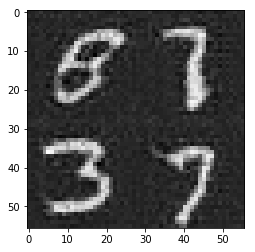

Epoch 1/2... Discriminator Loss: 0.0857... Generator Loss: 3.1611
Epoch 1/2... Discriminator Loss: 1.7608... Generator Loss: 0.4613
Epoch 1/2... Discriminator Loss: 0.6270... Generator Loss: 1.3266
Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 0.6773
Epoch 1/2... Discriminator Loss: 1.8241... Generator Loss: 0.2325
Epoch 1/2... Discriminator Loss: 0.4406... Generator Loss: 1.2207
Epoch 1/2... Discriminator Loss: 0.6950... Generator Loss: 1.1467
Epoch 1/2... Discriminator Loss: 0.5937... Generator Loss: 1.0772
Epoch 1/2... Discriminator Loss: 1.4276... Generator Loss: 0.4314
Epoch 1/2... Discriminator Loss: 0.3095... Generator Loss: 1.6012


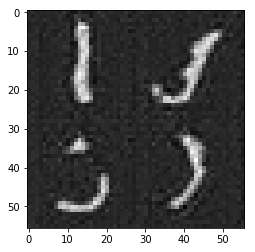

Epoch 1/2... Discriminator Loss: 1.5528... Generator Loss: 0.6144
Epoch 1/2... Discriminator Loss: 0.3295... Generator Loss: 1.9226
Epoch 1/2... Discriminator Loss: 0.2588... Generator Loss: 2.0985
Epoch 1/2... Discriminator Loss: 0.1891... Generator Loss: 2.1199
Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 0.4367
Epoch 1/2... Discriminator Loss: 0.1383... Generator Loss: 2.5618
Epoch 1/2... Discriminator Loss: 0.4022... Generator Loss: 1.5609
Epoch 1/2... Discriminator Loss: 0.0729... Generator Loss: 3.8776
Epoch 1/2... Discriminator Loss: 0.0280... Generator Loss: 4.2009
Epoch 1/2... Discriminator Loss: 0.0523... Generator Loss: 3.6582


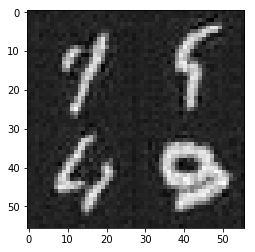

Epoch 1/2... Discriminator Loss: 0.0054... Generator Loss: 5.9252
Epoch 1/2... Discriminator Loss: 0.1080... Generator Loss: 2.7912
Epoch 1/2... Discriminator Loss: 0.9835... Generator Loss: 0.6170
Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 0.5430
Epoch 1/2... Discriminator Loss: 0.0280... Generator Loss: 6.2872
Epoch 1/2... Discriminator Loss: 0.2923... Generator Loss: 2.1544
Epoch 1/2... Discriminator Loss: 0.0574... Generator Loss: 3.2891
Epoch 1/2... Discriminator Loss: 0.0551... Generator Loss: 3.3815
Epoch 1/2... Discriminator Loss: 1.9624... Generator Loss: 0.8197
Epoch 1/2... Discriminator Loss: 0.0969... Generator Loss: 3.2818


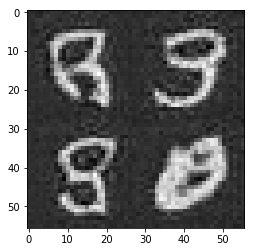

Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.7768
Epoch 1/2... Discriminator Loss: 0.2952... Generator Loss: 1.9406
Epoch 1/2... Discriminator Loss: 1.0980... Generator Loss: 0.5942
Epoch 1/2... Discriminator Loss: 0.2315... Generator Loss: 2.4242
Epoch 1/2... Discriminator Loss: 0.0714... Generator Loss: 3.3074
Epoch 1/2... Discriminator Loss: 0.6735... Generator Loss: 0.9141
Epoch 1/2... Discriminator Loss: 0.0457... Generator Loss: 4.4927
Epoch 1/2... Discriminator Loss: 0.0471... Generator Loss: 3.8045
Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 0.4011
Epoch 1/2... Discriminator Loss: 0.0122... Generator Loss: 7.8728


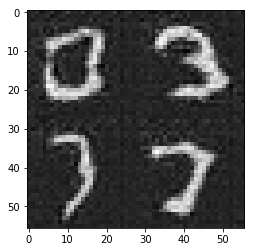

Epoch 1/2... Discriminator Loss: 0.0082... Generator Loss: 6.4477
Epoch 1/2... Discriminator Loss: 0.0598... Generator Loss: 3.1508
Epoch 1/2... Discriminator Loss: 2.1535... Generator Loss: 9.7671
Epoch 1/2... Discriminator Loss: 0.3492... Generator Loss: 1.8975
Epoch 1/2... Discriminator Loss: 0.5668... Generator Loss: 1.3609
Epoch 1/2... Discriminator Loss: 0.4535... Generator Loss: 1.4795
Epoch 1/2... Discriminator Loss: 0.2404... Generator Loss: 2.9251
Epoch 1/2... Discriminator Loss: 0.1988... Generator Loss: 2.7493
Epoch 1/2... Discriminator Loss: 0.3960... Generator Loss: 1.4412
Epoch 1/2... Discriminator Loss: 0.3644... Generator Loss: 1.5279


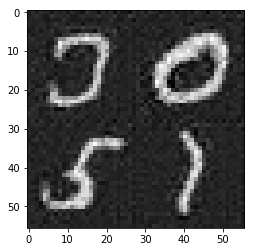

Epoch 1/2... Discriminator Loss: 0.8573... Generator Loss: 2.9596
Epoch 1/2... Discriminator Loss: 1.1574... Generator Loss: 0.5085
Epoch 1/2... Discriminator Loss: 0.2989... Generator Loss: 2.4402
Epoch 1/2... Discriminator Loss: 0.6162... Generator Loss: 1.1751
Epoch 1/2... Discriminator Loss: 0.5008... Generator Loss: 2.0450
Epoch 1/2... Discriminator Loss: 0.2916... Generator Loss: 1.5050
Epoch 1/2... Discriminator Loss: 0.7954... Generator Loss: 0.7136
Epoch 1/2... Discriminator Loss: 0.2616... Generator Loss: 2.4301
Epoch 1/2... Discriminator Loss: 0.6216... Generator Loss: 1.0798
Epoch 1/2... Discriminator Loss: 0.0465... Generator Loss: 4.6550


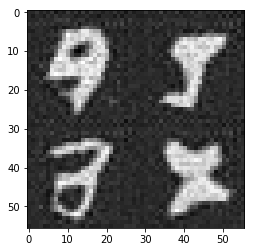

Epoch 1/2... Discriminator Loss: 0.2498... Generator Loss: 1.7290
Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 0.5644
Epoch 1/2... Discriminator Loss: 1.9125... Generator Loss: 0.3551
Epoch 1/2... Discriminator Loss: 0.9009... Generator Loss: 0.7474
Epoch 1/2... Discriminator Loss: 0.1772... Generator Loss: 2.2328
Epoch 1/2... Discriminator Loss: 0.0065... Generator Loss: 5.9735
Epoch 1/2... Discriminator Loss: 0.0715... Generator Loss: 3.3603
Epoch 1/2... Discriminator Loss: 0.8988... Generator Loss: 0.7238
Epoch 1/2... Discriminator Loss: 2.2086... Generator Loss: 0.4412
Epoch 1/2... Discriminator Loss: 0.2813... Generator Loss: 2.0886


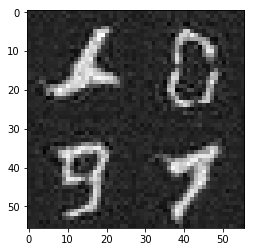

Epoch 1/2... Discriminator Loss: 2.2200... Generator Loss: 0.1890
Epoch 1/2... Discriminator Loss: 1.4904... Generator Loss: 13.1844
Epoch 1/2... Discriminator Loss: 1.7333... Generator Loss: 0.3563
Epoch 1/2... Discriminator Loss: 0.1142... Generator Loss: 2.9731
Epoch 1/2... Discriminator Loss: 1.5805... Generator Loss: 0.4045
Epoch 1/2... Discriminator Loss: 2.5751... Generator Loss: 0.1018
Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 2.0669
Epoch 1/2... Discriminator Loss: 0.3377... Generator Loss: 2.2703
Epoch 1/2... Discriminator Loss: 0.6021... Generator Loss: 2.0216
Epoch 1/2... Discriminator Loss: 0.5526... Generator Loss: 1.9290


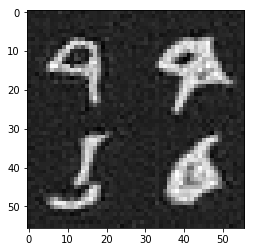

Epoch 1/2... Discriminator Loss: 0.3010... Generator Loss: 1.9680
Epoch 1/2... Discriminator Loss: 2.7118... Generator Loss: 0.1478
Epoch 1/2... Discriminator Loss: 0.0850... Generator Loss: 3.5791
Epoch 1/2... Discriminator Loss: 0.0349... Generator Loss: 4.2540
Epoch 1/2... Discriminator Loss: 0.5583... Generator Loss: 1.2013
Epoch 1/2... Discriminator Loss: 0.1668... Generator Loss: 2.1988
Epoch 1/2... Discriminator Loss: 0.0289... Generator Loss: 4.3194
Epoch 1/2... Discriminator Loss: 0.0892... Generator Loss: 3.5559
Epoch 1/2... Discriminator Loss: 0.1934... Generator Loss: 2.1661
Epoch 1/2... Discriminator Loss: 0.0725... Generator Loss: 5.8723


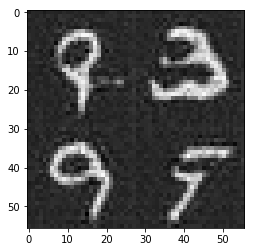

Epoch 1/2... Discriminator Loss: 0.0571... Generator Loss: 3.9690
Epoch 1/2... Discriminator Loss: 0.0011... Generator Loss: 8.6354
Epoch 1/2... Discriminator Loss: 0.8612... Generator Loss: 0.9009
Epoch 1/2... Discriminator Loss: 0.0330... Generator Loss: 3.9439
Epoch 1/2... Discriminator Loss: 0.5827... Generator Loss: 1.3540
Epoch 1/2... Discriminator Loss: 0.1968... Generator Loss: 2.4992
Epoch 1/2... Discriminator Loss: 0.0414... Generator Loss: 3.6611
Epoch 1/2... Discriminator Loss: 0.4111... Generator Loss: 1.5174
Epoch 1/2... Discriminator Loss: 0.4401... Generator Loss: 1.3489
Epoch 1/2... Discriminator Loss: 0.0027... Generator Loss: 6.8636


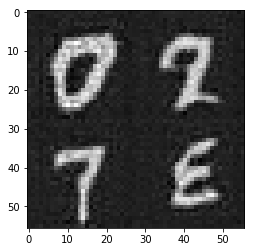

Epoch 1/2... Discriminator Loss: 0.0395... Generator Loss: 4.1495
Epoch 1/2... Discriminator Loss: 0.0086... Generator Loss: 5.2551
Epoch 1/2... Discriminator Loss: 0.0166... Generator Loss: 4.9769
Epoch 1/2... Discriminator Loss: 0.7176... Generator Loss: 0.8883
Epoch 1/2... Discriminator Loss: 1.2859... Generator Loss: 0.5110
Epoch 1/2... Discriminator Loss: 0.6508... Generator Loss: 0.9253
Epoch 1/2... Discriminator Loss: 0.0457... Generator Loss: 4.4209
Epoch 1/2... Discriminator Loss: 0.7578... Generator Loss: 7.7892
Epoch 1/2... Discriminator Loss: 0.5396... Generator Loss: 1.4808
Epoch 1/2... Discriminator Loss: 0.6809... Generator Loss: 0.9516


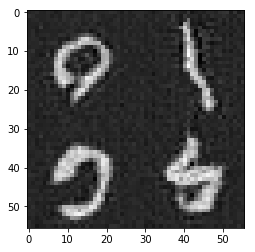

Epoch 1/2... Discriminator Loss: 2.8256... Generator Loss: 0.1213
Epoch 1/2... Discriminator Loss: 3.2748... Generator Loss: 0.1322
Epoch 1/2... Discriminator Loss: 0.5662... Generator Loss: 1.4984
Epoch 1/2... Discriminator Loss: 2.7669... Generator Loss: 5.9898
Epoch 1/2... Discriminator Loss: 0.2937... Generator Loss: 7.5739
Epoch 1/2... Discriminator Loss: 0.5842... Generator Loss: 0.9754
Epoch 1/2... Discriminator Loss: 0.2538... Generator Loss: 1.7038
Epoch 1/2... Discriminator Loss: 0.5691... Generator Loss: 1.1182
Epoch 1/2... Discriminator Loss: 0.3801... Generator Loss: 1.8283
Epoch 1/2... Discriminator Loss: 0.1127... Generator Loss: 3.0419


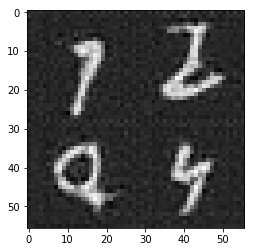

Epoch 2/2... Discriminator Loss: 0.3339... Generator Loss: 2.1012
Epoch 2/2... Discriminator Loss: 0.6415... Generator Loss: 1.6792
Epoch 2/2... Discriminator Loss: 0.0512... Generator Loss: 3.5500
Epoch 2/2... Discriminator Loss: 2.1736... Generator Loss: 0.2589
Epoch 2/2... Discriminator Loss: 0.6055... Generator Loss: 1.1371
Epoch 2/2... Discriminator Loss: 1.5307... Generator Loss: 0.3633
Epoch 2/2... Discriminator Loss: 0.4604... Generator Loss: 1.2116
Epoch 2/2... Discriminator Loss: 0.6959... Generator Loss: 0.9546
Epoch 2/2... Discriminator Loss: 0.4406... Generator Loss: 1.3316
Epoch 2/2... Discriminator Loss: 0.4660... Generator Loss: 1.4933


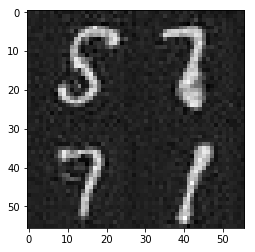

Epoch 2/2... Discriminator Loss: 0.0180... Generator Loss: 6.6774
Epoch 2/2... Discriminator Loss: 0.8429... Generator Loss: 0.6766
Epoch 2/2... Discriminator Loss: 0.1683... Generator Loss: 2.0721
Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 0.8202
Epoch 2/2... Discriminator Loss: 0.3854... Generator Loss: 1.4987
Epoch 2/2... Discriminator Loss: 0.6962... Generator Loss: 1.3194
Epoch 2/2... Discriminator Loss: 0.8756... Generator Loss: 0.9304
Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 0.6372
Epoch 2/2... Discriminator Loss: 1.0696... Generator Loss: 0.6762
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 0.9009


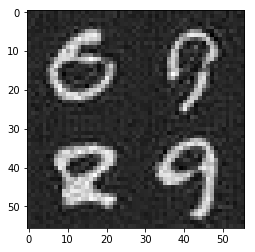

Epoch 2/2... Discriminator Loss: 0.1702... Generator Loss: 2.2448
Epoch 2/2... Discriminator Loss: 0.3459... Generator Loss: 1.6739
Epoch 2/2... Discriminator Loss: 0.4323... Generator Loss: 1.2281
Epoch 2/2... Discriminator Loss: 0.0533... Generator Loss: 3.3514
Epoch 2/2... Discriminator Loss: 0.0437... Generator Loss: 4.1341
Epoch 2/2... Discriminator Loss: 2.2346... Generator Loss: 0.3496
Epoch 2/2... Discriminator Loss: 0.2040... Generator Loss: 1.8540
Epoch 2/2... Discriminator Loss: 0.1501... Generator Loss: 2.3781
Epoch 2/2... Discriminator Loss: 0.5509... Generator Loss: 1.3814
Epoch 2/2... Discriminator Loss: 1.2451... Generator Loss: 0.7154


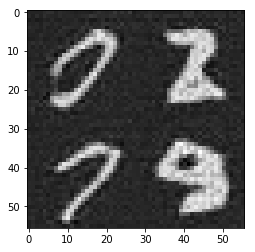

Epoch 2/2... Discriminator Loss: 2.0544... Generator Loss: 8.5002
Epoch 2/2... Discriminator Loss: 0.2986... Generator Loss: 2.2275
Epoch 2/2... Discriminator Loss: 2.5269... Generator Loss: 0.2457
Epoch 2/2... Discriminator Loss: 0.3741... Generator Loss: 1.5579
Epoch 2/2... Discriminator Loss: 0.0636... Generator Loss: 6.1192
Epoch 2/2... Discriminator Loss: 0.1299... Generator Loss: 2.3840
Epoch 2/2... Discriminator Loss: 0.8797... Generator Loss: 0.6433
Epoch 2/2... Discriminator Loss: 1.6339... Generator Loss: 0.2923
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 0.5109
Epoch 2/2... Discriminator Loss: 1.1143... Generator Loss: 0.7169


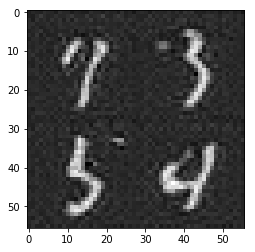

Epoch 2/2... Discriminator Loss: 1.1254... Generator Loss: 0.9646
Epoch 2/2... Discriminator Loss: 0.3083... Generator Loss: 1.9017
Epoch 2/2... Discriminator Loss: 0.0512... Generator Loss: 3.8461
Epoch 2/2... Discriminator Loss: 0.2115... Generator Loss: 2.0230
Epoch 2/2... Discriminator Loss: 1.5395... Generator Loss: 0.3121
Epoch 2/2... Discriminator Loss: 0.3600... Generator Loss: 1.5396
Epoch 2/2... Discriminator Loss: 1.0095... Generator Loss: 0.9374
Epoch 2/2... Discriminator Loss: 0.5415... Generator Loss: 1.4648
Epoch 2/2... Discriminator Loss: 0.0635... Generator Loss: 3.9551
Epoch 2/2... Discriminator Loss: 1.6168... Generator Loss: 0.2933


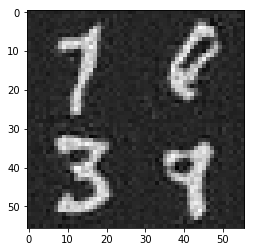

Epoch 2/2... Discriminator Loss: 1.5003... Generator Loss: 0.3361
Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 0.5841
Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 0.7438
Epoch 2/2... Discriminator Loss: 0.5189... Generator Loss: 1.3440
Epoch 2/2... Discriminator Loss: 0.0704... Generator Loss: 2.9834
Epoch 2/2... Discriminator Loss: 0.2601... Generator Loss: 2.2972
Epoch 2/2... Discriminator Loss: 2.4574... Generator Loss: 0.0986
Epoch 2/2... Discriminator Loss: 2.9323... Generator Loss: 0.1503
Epoch 2/2... Discriminator Loss: 2.6569... Generator Loss: 0.2030
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 0.6535


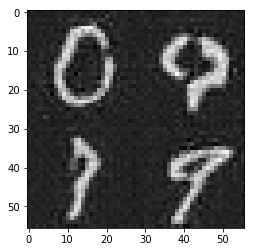

Epoch 2/2... Discriminator Loss: 0.0068... Generator Loss: 6.4339
Epoch 2/2... Discriminator Loss: 0.3245... Generator Loss: 1.6921
Epoch 2/2... Discriminator Loss: 0.4632... Generator Loss: 1.2638
Epoch 2/2... Discriminator Loss: 0.0035... Generator Loss: 6.9877
Epoch 2/2... Discriminator Loss: 0.1070... Generator Loss: 2.9862
Epoch 2/2... Discriminator Loss: 0.7787... Generator Loss: 0.8008
Epoch 2/2... Discriminator Loss: 0.0420... Generator Loss: 3.9963
Epoch 2/2... Discriminator Loss: 3.6497... Generator Loss: 0.1068
Epoch 2/2... Discriminator Loss: 0.1307... Generator Loss: 2.9344
Epoch 2/2... Discriminator Loss: 0.0664... Generator Loss: 3.0487


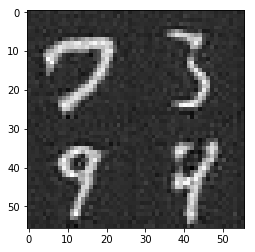

Epoch 2/2... Discriminator Loss: 0.3691... Generator Loss: 2.5196
Epoch 2/2... Discriminator Loss: 0.6320... Generator Loss: 1.1167
Epoch 2/2... Discriminator Loss: 0.0481... Generator Loss: 5.4449
Epoch 2/2... Discriminator Loss: 0.0662... Generator Loss: 3.8247
Epoch 2/2... Discriminator Loss: 1.2283... Generator Loss: 0.4474
Epoch 2/2... Discriminator Loss: 0.0084... Generator Loss: 7.1074
Epoch 2/2... Discriminator Loss: 0.0420... Generator Loss: 4.0562
Epoch 2/2... Discriminator Loss: 4.0584... Generator Loss: 16.2212
Epoch 2/2... Discriminator Loss: 0.8696... Generator Loss: 0.9640
Epoch 2/2... Discriminator Loss: 0.5561... Generator Loss: 1.2594


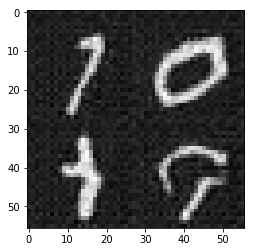

Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.1495
Epoch 2/2... Discriminator Loss: 0.6128... Generator Loss: 1.2401
Epoch 2/2... Discriminator Loss: 0.1436... Generator Loss: 3.7617
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 0.6945... Generator Loss: 1.2987
Epoch 2/2... Discriminator Loss: 0.1314... Generator Loss: 3.2681
Epoch 2/2... Discriminator Loss: 0.2803... Generator Loss: 1.8055
Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 0.1671... Generator Loss: 2.2388
Epoch 2/2... Discriminator Loss: 0.1549... Generator Loss: 2.1072


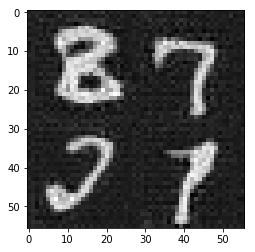

Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 4.2476
Epoch 2/2... Discriminator Loss: 1.2279... Generator Loss: 0.4477
Epoch 2/2... Discriminator Loss: 0.6170... Generator Loss: 1.0938
Epoch 2/2... Discriminator Loss: 1.5882... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 0.3528... Generator Loss: 1.8776
Epoch 2/2... Discriminator Loss: 0.2314... Generator Loss: 2.4235
Epoch 2/2... Discriminator Loss: 2.1502... Generator Loss: 0.1555
Epoch 2/2... Discriminator Loss: 0.9141... Generator Loss: 0.8071
Epoch 2/2... Discriminator Loss: 1.7045... Generator Loss: 0.2491
Epoch 2/2... Discriminator Loss: 1.1116... Generator Loss: 0.7885


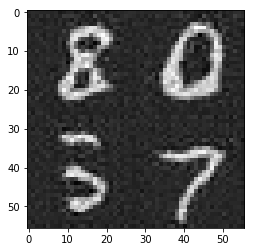

Epoch 2/2... Discriminator Loss: 0.0218... Generator Loss: 5.3841
Epoch 2/2... Discriminator Loss: 2.0629... Generator Loss: 0.3951
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 0.9012
Epoch 2/2... Discriminator Loss: 1.3009... Generator Loss: 0.5975
Epoch 2/2... Discriminator Loss: 3.3521... Generator Loss: 0.0433
Epoch 2/2... Discriminator Loss: 0.9416... Generator Loss: 0.9202
Epoch 2/2... Discriminator Loss: 0.5793... Generator Loss: 1.4258
Epoch 2/2... Discriminator Loss: 0.2959... Generator Loss: 1.8039
Epoch 2/2... Discriminator Loss: 0.7218... Generator Loss: 0.8864
Epoch 2/2... Discriminator Loss: 0.0481... Generator Loss: 4.0493


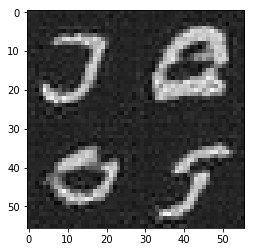

Epoch 2/2... Discriminator Loss: 0.0483... Generator Loss: 4.2857
Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 0.8114
Epoch 2/2... Discriminator Loss: 0.1061... Generator Loss: 2.5128
Epoch 2/2... Discriminator Loss: 0.7013... Generator Loss: 1.0008
Epoch 2/2... Discriminator Loss: 0.0025... Generator Loss: 6.2980
Epoch 2/2... Discriminator Loss: 0.0180... Generator Loss: 5.0538
Epoch 2/2... Discriminator Loss: 3.7382... Generator Loss: 0.0485
Epoch 2/2... Discriminator Loss: 1.2677... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 0.7200... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 0.0809... Generator Loss: 3.1865


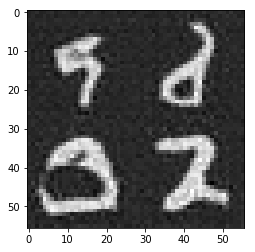

Epoch 2/2... Discriminator Loss: 2.4789... Generator Loss: 0.1221
Epoch 2/2... Discriminator Loss: 0.5668... Generator Loss: 1.2253
Epoch 2/2... Discriminator Loss: 0.2855... Generator Loss: 1.7668
Epoch 2/2... Discriminator Loss: 0.5456... Generator Loss: 1.2676
Epoch 2/2... Discriminator Loss: 3.3150... Generator Loss: 0.0672
Epoch 2/2... Discriminator Loss: 0.0639... Generator Loss: 5.0888
Epoch 2/2... Discriminator Loss: 0.0606... Generator Loss: 3.7362
Epoch 2/2... Discriminator Loss: 0.0504... Generator Loss: 4.0962
Epoch 2/2... Discriminator Loss: 0.8728... Generator Loss: 1.8471
Epoch 2/2... Discriminator Loss: 1.4314... Generator Loss: 0.5543


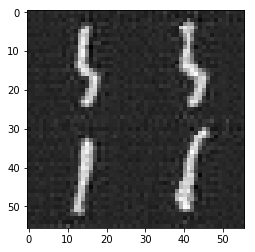

Epoch 2/2... Discriminator Loss: 0.3631... Generator Loss: 2.0233
Epoch 2/2... Discriminator Loss: 0.6955... Generator Loss: 1.3433
Epoch 2/2... Discriminator Loss: 0.0952... Generator Loss: 3.3266
Epoch 2/2... Discriminator Loss: 0.0009... Generator Loss: 7.8876
Epoch 2/2... Discriminator Loss: 0.7113... Generator Loss: 1.3124
Epoch 2/2... Discriminator Loss: 1.4829... Generator Loss: 0.5286
Epoch 2/2... Discriminator Loss: 0.8684... Generator Loss: 1.0758
Epoch 2/2... Discriminator Loss: 3.7420... Generator Loss: 0.0734
Epoch 2/2... Discriminator Loss: 0.2385... Generator Loss: 2.8763
Epoch 2/2... Discriminator Loss: 0.5625... Generator Loss: 1.3775


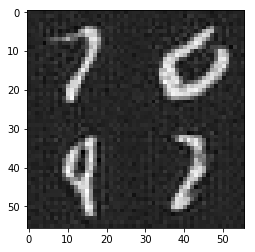

Epoch 2/2... Discriminator Loss: 1.6603... Generator Loss: 0.4634
Epoch 2/2... Discriminator Loss: 0.2503... Generator Loss: 2.8640
Epoch 2/2... Discriminator Loss: 0.6634... Generator Loss: 1.2940
Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 0.8171
Epoch 2/2... Discriminator Loss: 1.8271... Generator Loss: 0.3648
Epoch 2/2... Discriminator Loss: 0.6933... Generator Loss: 1.8858
Epoch 2/2... Discriminator Loss: 0.7014... Generator Loss: 0.8936
Epoch 2/2... Discriminator Loss: 0.4053... Generator Loss: 1.4731
Epoch 2/2... Discriminator Loss: 1.8417... Generator Loss: 0.3079
Epoch 2/2... Discriminator Loss: 1.4307... Generator Loss: 0.7687


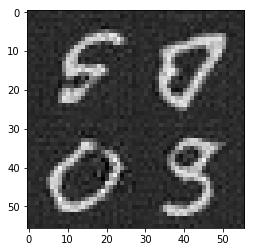

Epoch 2/2... Discriminator Loss: 0.5881... Generator Loss: 1.8370
Epoch 2/2... Discriminator Loss: 0.1222... Generator Loss: 3.2863
Epoch 2/2... Discriminator Loss: 0.2252... Generator Loss: 1.8619
Epoch 2/2... Discriminator Loss: 1.2335... Generator Loss: 0.6824
Epoch 2/2... Discriminator Loss: 0.7522... Generator Loss: 1.2084
Epoch 2/2... Discriminator Loss: 0.4889... Generator Loss: 1.3749
Epoch 2/2... Discriminator Loss: 0.0785... Generator Loss: 4.1572
Epoch 2/2... Discriminator Loss: 0.0053... Generator Loss: 6.1132
Epoch 2/2... Discriminator Loss: 0.5762... Generator Loss: 1.7276
Epoch 2/2... Discriminator Loss: 0.0073... Generator Loss: 6.8827


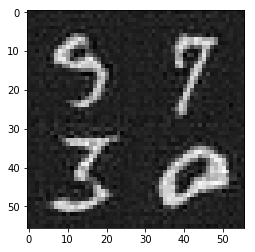

Epoch 2/2... Discriminator Loss: 0.7766... Generator Loss: 1.0747
Epoch 2/2... Discriminator Loss: 0.8702... Generator Loss: 0.8066
Epoch 2/2... Discriminator Loss: 0.2134... Generator Loss: 2.8766
Epoch 2/2... Discriminator Loss: 0.7089... Generator Loss: 1.4719
Epoch 2/2... Discriminator Loss: 0.2201... Generator Loss: 2.7254
Epoch 2/2... Discriminator Loss: 0.2224... Generator Loss: 2.2463
Epoch 2/2... Discriminator Loss: 0.2731... Generator Loss: 2.3548
Epoch 2/2... Discriminator Loss: 1.3316... Generator Loss: 7.2647
Epoch 2/2... Discriminator Loss: 0.2267... Generator Loss: 2.1127
Epoch 2/2... Discriminator Loss: 0.2297... Generator Loss: 2.3197


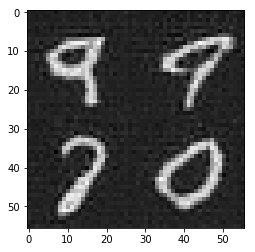

Epoch 2/2... Discriminator Loss: 0.0701... Generator Loss: 3.4644
Epoch 2/2... Discriminator Loss: 0.0230... Generator Loss: 5.1180
Epoch 2/2... Discriminator Loss: 2.0720... Generator Loss: 0.2310
Epoch 2/2... Discriminator Loss: 0.1175... Generator Loss: 3.0610
Epoch 2/2... Discriminator Loss: 0.0432... Generator Loss: 3.3632
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 0.7404
Epoch 2/2... Discriminator Loss: 0.4447... Generator Loss: 1.2909
Epoch 2/2... Discriminator Loss: 0.4317... Generator Loss: 1.1653
Epoch 2/2... Discriminator Loss: 0.0494... Generator Loss: 3.4338
Epoch 2/2... Discriminator Loss: 0.1876... Generator Loss: 1.7968


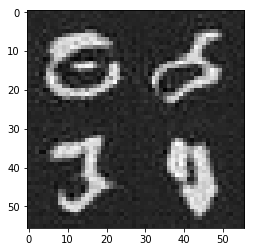

Epoch 2/2... Discriminator Loss: 0.4148... Generator Loss: 1.7320
Epoch 2/2... Discriminator Loss: 0.8854... Generator Loss: 0.8892
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 0.7932
Epoch 2/2... Discriminator Loss: 0.3887... Generator Loss: 1.6908
Epoch 2/2... Discriminator Loss: 2.1508... Generator Loss: 0.1715
Epoch 2/2... Discriminator Loss: 0.8696... Generator Loss: 0.9827
Epoch 2/2... Discriminator Loss: 0.0426... Generator Loss: 3.7266
Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 0.5397
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 0.8908
Epoch 2/2... Discriminator Loss: 0.1694... Generator Loss: 2.3103


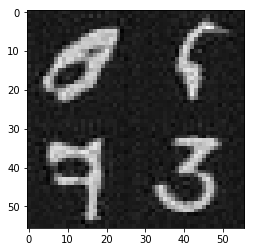

Epoch 2/2... Discriminator Loss: 0.2210... Generator Loss: 1.8098
Epoch 2/2... Discriminator Loss: 0.0205... Generator Loss: 4.3948
Epoch 2/2... Discriminator Loss: 0.5068... Generator Loss: 1.7000
Epoch 2/2... Discriminator Loss: 0.0042... Generator Loss: 6.0347
Epoch 2/2... Discriminator Loss: 0.1171... Generator Loss: 3.2544
Epoch 2/2... Discriminator Loss: 2.8521... Generator Loss: 0.0918
Epoch 2/2... Discriminator Loss: 1.1069... Generator Loss: 0.5884
Epoch 2/2... Discriminator Loss: 0.1418... Generator Loss: 2.5446
Epoch 2/2... Discriminator Loss: 0.5404... Generator Loss: 1.4971
Epoch 2/2... Discriminator Loss: 0.1567... Generator Loss: 3.2281


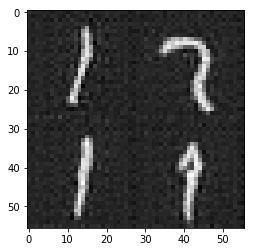

Epoch 2/2... Discriminator Loss: 0.7919... Generator Loss: 0.9355
Epoch 2/2... Discriminator Loss: 0.3067... Generator Loss: 2.3192
Epoch 2/2... Discriminator Loss: 0.6720... Generator Loss: 0.8975
Epoch 2/2... Discriminator Loss: 1.1586... Generator Loss: 0.5634
Epoch 2/2... Discriminator Loss: 0.2666... Generator Loss: 2.0157
Epoch 2/2... Discriminator Loss: 1.4290... Generator Loss: 0.5422
Epoch 2/2... Discriminator Loss: 0.0459... Generator Loss: 3.5690
Epoch 2/2... Discriminator Loss: 1.0369... Generator Loss: 0.4846
Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.9537
Epoch 2/2... Discriminator Loss: 0.2749... Generator Loss: 2.1165


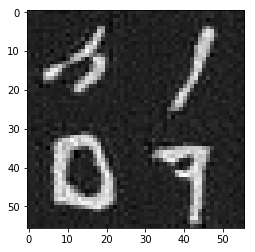

Epoch 2/2... Discriminator Loss: 1.9904... Generator Loss: 0.2714
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.5776
Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 0.5967
Epoch 2/2... Discriminator Loss: 0.4121... Generator Loss: 4.9150
Epoch 2/2... Discriminator Loss: 0.2147... Generator Loss: 2.2734
Epoch 2/2... Discriminator Loss: 1.4353... Generator Loss: 0.4271
Epoch 2/2... Discriminator Loss: 0.0132... Generator Loss: 5.8185
Epoch 2/2... Discriminator Loss: 0.6410... Generator Loss: 0.9332
Epoch 2/2... Discriminator Loss: 0.6950... Generator Loss: 1.3707
Epoch 2/2... Discriminator Loss: 0.8446... Generator Loss: 0.6405


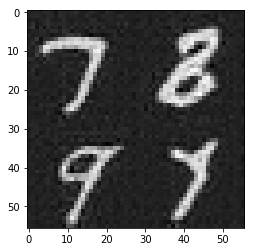

Epoch 2/2... Discriminator Loss: 0.2301... Generator Loss: 2.3934
Epoch 2/2... Discriminator Loss: 1.2530... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.2013... Generator Loss: 0.5177
Epoch 2/2... Discriminator Loss: 0.2010... Generator Loss: 2.5301
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 0.8958
Epoch 2/2... Discriminator Loss: 0.0449... Generator Loss: 3.8894
Epoch 2/2... Discriminator Loss: 0.5899... Generator Loss: 1.4674
Epoch 2/2... Discriminator Loss: 0.9163... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 3.2174... Generator Loss: 0.0522
Epoch 2/2... Discriminator Loss: 0.3249... Generator Loss: 2.2732


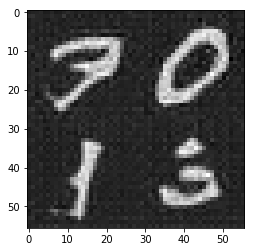

Epoch 2/2... Discriminator Loss: 0.5788... Generator Loss: 1.6790
Epoch 2/2... Discriminator Loss: 0.4557... Generator Loss: 1.5547
Epoch 2/2... Discriminator Loss: 1.3729... Generator Loss: 0.8669
Epoch 2/2... Discriminator Loss: 0.0553... Generator Loss: 3.5821
Epoch 2/2... Discriminator Loss: 0.4571... Generator Loss: 1.5619
Epoch 2/2... Discriminator Loss: 2.1557... Generator Loss: 0.2395
Epoch 2/2... Discriminator Loss: 0.0123... Generator Loss: 5.4024
Epoch 2/2... Discriminator Loss: 0.1653... Generator Loss: 2.6250
Epoch 2/2... Discriminator Loss: 0.4584... Generator Loss: 1.2046
Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 0.7740


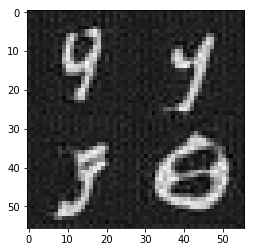

Epoch 2/2... Discriminator Loss: 3.1015... Generator Loss: 0.0696
Epoch 2/2... Discriminator Loss: 0.0408... Generator Loss: 4.4754
Epoch 2/2... Discriminator Loss: 0.2875... Generator Loss: 2.1822
Epoch 2/2... Discriminator Loss: 1.2563... Generator Loss: 0.6366
Epoch 2/2... Discriminator Loss: 1.7320... Generator Loss: 0.2676
Epoch 2/2... Discriminator Loss: 0.2623... Generator Loss: 2.8479
Epoch 2/2... Discriminator Loss: 0.1083... Generator Loss: 2.9444
Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 0.5093
Epoch 2/2... Discriminator Loss: 0.1465... Generator Loss: 2.7649
Epoch 2/2... Discriminator Loss: 0.9307... Generator Loss: 1.0966


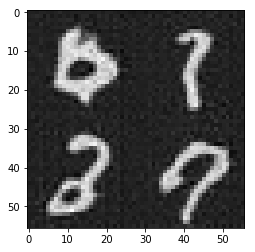

Epoch 2/2... Discriminator Loss: 0.5017... Generator Loss: 1.6687
Epoch 2/2... Discriminator Loss: 0.7643... Generator Loss: 2.0060
Epoch 2/2... Discriminator Loss: 0.5000... Generator Loss: 1.1973
Epoch 2/2... Discriminator Loss: 0.0835... Generator Loss: 3.0703
Epoch 2/2... Discriminator Loss: 0.1234... Generator Loss: 3.8587
Epoch 2/2... Discriminator Loss: 0.9107... Generator Loss: 0.8958
Epoch 2/2... Discriminator Loss: 0.7858... Generator Loss: 1.3862
Epoch 2/2... Discriminator Loss: 0.0902... Generator Loss: 3.1751
Epoch 2/2... Discriminator Loss: 0.2167... Generator Loss: 2.0410
Epoch 2/2... Discriminator Loss: 0.9036... Generator Loss: 1.0883


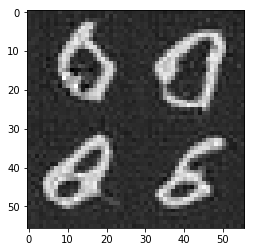

Epoch 2/2... Discriminator Loss: 1.6301... Generator Loss: 0.5102
Epoch 2/2... Discriminator Loss: 0.5770... Generator Loss: 0.9373
Epoch 2/2... Discriminator Loss: 0.3398... Generator Loss: 1.4581
Epoch 2/2... Discriminator Loss: 3.0138... Generator Loss: 0.0806
Epoch 2/2... Discriminator Loss: 2.3299... Generator Loss: 0.2784
Epoch 2/2... Discriminator Loss: 0.0454... Generator Loss: 3.7423
Epoch 2/2... Discriminator Loss: 0.3203... Generator Loss: 1.6021
Epoch 2/2... Discriminator Loss: 0.2265... Generator Loss: 4.8425
Epoch 2/2... Discriminator Loss: 0.1028... Generator Loss: 3.2204
Epoch 2/2... Discriminator Loss: 1.0863... Generator Loss: 0.6186


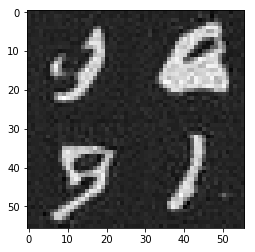

Epoch 2/2... Discriminator Loss: 0.5006... Generator Loss: 1.2347
Epoch 2/2... Discriminator Loss: 0.2065... Generator Loss: 2.4076
Epoch 2/2... Discriminator Loss: 0.2295... Generator Loss: 2.9635
Epoch 2/2... Discriminator Loss: 0.0682... Generator Loss: 3.3034
Epoch 2/2... Discriminator Loss: 0.8222... Generator Loss: 1.1099
Epoch 2/2... Discriminator Loss: 3.3475... Generator Loss: 0.1045
Epoch 2/2... Discriminator Loss: 0.4817... Generator Loss: 1.4405
Epoch 2/2... Discriminator Loss: 1.9902... Generator Loss: 0.2000
Epoch 2/2... Discriminator Loss: 0.8204... Generator Loss: 1.2987
Epoch 2/2... Discriminator Loss: 0.3130... Generator Loss: 2.2822


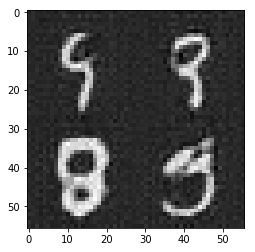

Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.4398
Epoch 2/2... Discriminator Loss: 0.7603... Generator Loss: 13.1046
Epoch 2/2... Discriminator Loss: 1.7338... Generator Loss: 0.2512
Epoch 2/2... Discriminator Loss: 0.4119... Generator Loss: 2.3191
Epoch 2/2... Discriminator Loss: 1.0657... Generator Loss: 0.5823
Epoch 2/2... Discriminator Loss: 2.9384... Generator Loss: 0.0735
Epoch 2/2... Discriminator Loss: 0.0257... Generator Loss: 4.6924
Epoch 2/2... Discriminator Loss: 1.2160... Generator Loss: 0.4911
Epoch 2/2... Discriminator Loss: 1.0588... Generator Loss: 0.7298
Epoch 2/2... Discriminator Loss: 1.0509... Generator Loss: 1.1791


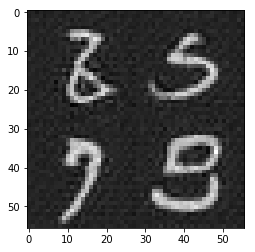

Epoch 2/2... Discriminator Loss: 0.4281... Generator Loss: 1.6242
Epoch 2/2... Discriminator Loss: 0.6753... Generator Loss: 0.7579
Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 0.5457
Epoch 2/2... Discriminator Loss: 0.9942... Generator Loss: 1.0261
Epoch 2/2... Discriminator Loss: 0.7667... Generator Loss: 0.9182
Epoch 2/2... Discriminator Loss: 0.8717... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 1.8295... Generator Loss: 0.3117
Epoch 2/2... Discriminator Loss: 0.6985... Generator Loss: 2.4416
Epoch 2/2... Discriminator Loss: 0.5958... Generator Loss: 1.3494
Epoch 2/2... Discriminator Loss: 1.4962... Generator Loss: 0.4225


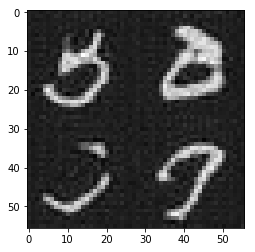

Epoch 2/2... Discriminator Loss: 0.3982... Generator Loss: 1.8030
Epoch 2/2... Discriminator Loss: 0.0790... Generator Loss: 2.9885
Epoch 2/2... Discriminator Loss: 0.5940... Generator Loss: 0.9945
Epoch 2/2... Discriminator Loss: 0.2179... Generator Loss: 1.8994
Epoch 2/2... Discriminator Loss: 0.4197... Generator Loss: 1.4977
Epoch 2/2... Discriminator Loss: 0.0605... Generator Loss: 3.3588
Epoch 2/2... Discriminator Loss: 0.4897... Generator Loss: 1.4747
Epoch 2/2... Discriminator Loss: 0.0944... Generator Loss: 3.3333
Epoch 2/2... Discriminator Loss: 0.9628... Generator Loss: 0.7809
Epoch 2/2... Discriminator Loss: 1.1893... Generator Loss: 0.7214


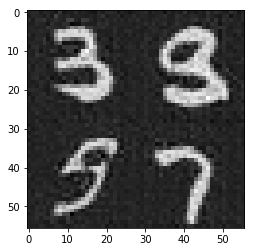

Epoch 2/2... Discriminator Loss: 1.7108... Generator Loss: 0.4697
Epoch 2/2... Discriminator Loss: 0.0349... Generator Loss: 3.7711
Epoch 2/2... Discriminator Loss: 1.1238... Generator Loss: 0.7355
Epoch 2/2... Discriminator Loss: 0.7382... Generator Loss: 1.1096
Epoch 2/2... Discriminator Loss: 0.4245... Generator Loss: 1.3399
Epoch 2/2... Discriminator Loss: 0.9238... Generator Loss: 0.8454
Epoch 2/2... Discriminator Loss: 0.1277... Generator Loss: 2.9303
Epoch 2/2... Discriminator Loss: 1.4297... Generator Loss: 0.4551
Epoch 2/2... Discriminator Loss: 1.0315... Generator Loss: 0.5701
Epoch 2/2... Discriminator Loss: 0.3493... Generator Loss: 1.5997


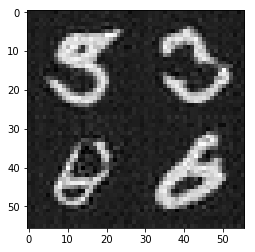

Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 0.4946
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 0.8432
Epoch 2/2... Discriminator Loss: 0.3847... Generator Loss: 1.4921
Epoch 2/2... Discriminator Loss: 0.1159... Generator Loss: 3.6609
Epoch 2/2... Discriminator Loss: 0.7060... Generator Loss: 0.9704
Epoch 2/2... Discriminator Loss: 1.8850... Generator Loss: 0.2679
Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 1.5422
Epoch 2/2... Discriminator Loss: 0.4656... Generator Loss: 1.2554
Epoch 2/2... Discriminator Loss: 0.0788... Generator Loss: 2.9880
Epoch 2/2... Discriminator Loss: 0.0480... Generator Loss: 4.0295


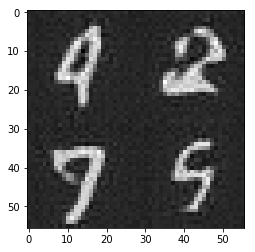

Epoch 2/2... Discriminator Loss: 0.5795... Generator Loss: 1.7536
Epoch 2/2... Discriminator Loss: 0.0231... Generator Loss: 4.4348
Epoch 2/2... Discriminator Loss: 1.1107... Generator Loss: 0.5819
Epoch 2/2... Discriminator Loss: 3.0247... Generator Loss: 0.0839
Epoch 2/2... Discriminator Loss: 1.4331... Generator Loss: 0.7366
Epoch 2/2... Discriminator Loss: 4.3677... Generator Loss: 0.0255
Epoch 2/2... Discriminator Loss: 0.0459... Generator Loss: 4.1164
Epoch 2/2... Discriminator Loss: 2.3833... Generator Loss: 0.2566
Epoch 2/2... Discriminator Loss: 0.0481... Generator Loss: 3.8627
Epoch 2/2... Discriminator Loss: 0.2022... Generator Loss: 2.1688


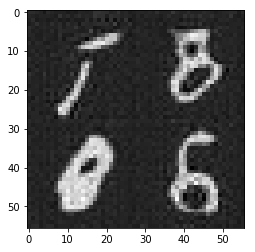

Epoch 2/2... Discriminator Loss: 1.3075... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 0.0208... Generator Loss: 5.4777
Epoch 2/2... Discriminator Loss: 0.2446... Generator Loss: 1.9636
Epoch 2/2... Discriminator Loss: 0.1141... Generator Loss: 2.7157
Epoch 2/2... Discriminator Loss: 1.5870... Generator Loss: 0.4453
Epoch 2/2... Discriminator Loss: 0.0192... Generator Loss: 5.4310
Epoch 2/2... Discriminator Loss: 0.7952... Generator Loss: 0.8413
Epoch 2/2... Discriminator Loss: 0.2258... Generator Loss: 2.1274
Epoch 2/2... Discriminator Loss: 0.0252... Generator Loss: 4.8289
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.8215


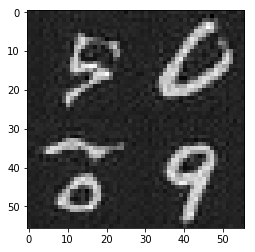

Epoch 2/2... Discriminator Loss: 3.7562... Generator Loss: 0.0409
Epoch 2/2... Discriminator Loss: 0.0619... Generator Loss: 3.6816
Epoch 2/2... Discriminator Loss: 0.1125... Generator Loss: 2.6454
Epoch 2/2... Discriminator Loss: 1.7315... Generator Loss: 0.2645
Epoch 2/2... Discriminator Loss: 0.0347... Generator Loss: 5.0142
Epoch 2/2... Discriminator Loss: 1.2801... Generator Loss: 0.5890
Epoch 2/2... Discriminator Loss: 1.0269... Generator Loss: 0.7451
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.4486
Epoch 2/2... Discriminator Loss: 0.0824... Generator Loss: 7.2455
Epoch 2/2... Discriminator Loss: 0.4792... Generator Loss: 1.4003


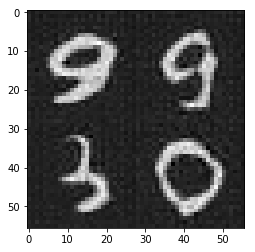

Epoch 2/2... Discriminator Loss: 3.3362... Generator Loss: 0.0379
Epoch 2/2... Discriminator Loss: 1.2226... Generator Loss: 0.5327
Epoch 2/2... Discriminator Loss: 0.1500... Generator Loss: 2.4689
Epoch 2/2... Discriminator Loss: 0.1261... Generator Loss: 4.4998
Epoch 2/2... Discriminator Loss: 0.4899... Generator Loss: 1.1992
Epoch 2/2... Discriminator Loss: 0.6422... Generator Loss: 1.1208
Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 1.2192
Epoch 2/2... Discriminator Loss: 0.0357... Generator Loss: 3.7450
Epoch 2/2... Discriminator Loss: 2.3502... Generator Loss: 0.1615
Epoch 2/2... Discriminator Loss: 1.1289... Generator Loss: 0.6186


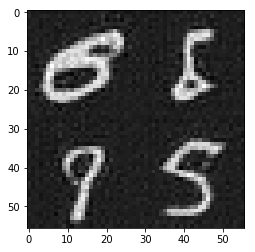

Epoch 2/2... Discriminator Loss: 3.5766... Generator Loss: 0.1716
Epoch 2/2... Discriminator Loss: 0.2797... Generator Loss: 2.4535
Epoch 2/2... Discriminator Loss: 1.5575... Generator Loss: 1.0127
Epoch 2/2... Discriminator Loss: 2.1553... Generator Loss: 0.2401
Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 0.8271
Epoch 2/2... Discriminator Loss: 0.0815... Generator Loss: 2.7803
Epoch 2/2... Discriminator Loss: 0.3550... Generator Loss: 1.7957
Epoch 2/2... Discriminator Loss: 0.5833... Generator Loss: 1.0150
Epoch 2/2... Discriminator Loss: 1.4222... Generator Loss: 0.4839
Epoch 2/2... Discriminator Loss: 1.9949... Generator Loss: 0.2635


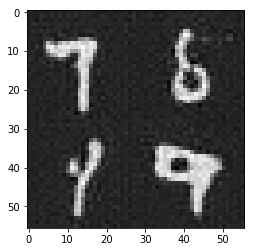

Epoch 2/2... Discriminator Loss: 1.2481... Generator Loss: 0.5606
Epoch 2/2... Discriminator Loss: 1.7177... Generator Loss: 0.4252
Epoch 2/2... Discriminator Loss: 0.5361... Generator Loss: 1.5665
Epoch 2/2... Discriminator Loss: 0.1621... Generator Loss: 2.6347
Epoch 2/2... Discriminator Loss: 0.0173... Generator Loss: 6.0308
Epoch 2/2... Discriminator Loss: 0.3889... Generator Loss: 2.7903
Epoch 2/2... Discriminator Loss: 2.3020... Generator Loss: 0.2668
Epoch 2/2... Discriminator Loss: 1.6626... Generator Loss: 0.5104
Epoch 2/2... Discriminator Loss: 0.0048... Generator Loss: 7.0021
Epoch 2/2... Discriminator Loss: 0.8162... Generator Loss: 1.6169


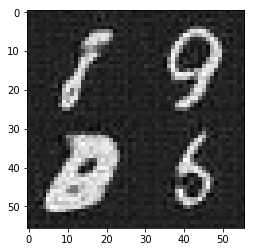

Epoch 2/2... Discriminator Loss: 1.6379... Generator Loss: 0.4660
Epoch 2/2... Discriminator Loss: 1.5459... Generator Loss: 0.3775
Epoch 2/2... Discriminator Loss: 5.0462... Generator Loss: 0.0088
Epoch 2/2... Discriminator Loss: 2.3150... Generator Loss: 0.4726
Epoch 2/2... Discriminator Loss: 0.1956... Generator Loss: 2.5310
Epoch 2/2... Discriminator Loss: 1.4183... Generator Loss: 0.4327
Epoch 2/2... Discriminator Loss: 0.1086... Generator Loss: 2.8503
Epoch 2/2... Discriminator Loss: 2.3060... Generator Loss: 0.2256
Epoch 2/2... Discriminator Loss: 1.1298... Generator Loss: 0.4688
Epoch 2/2... Discriminator Loss: 2.4962... Generator Loss: 0.2727


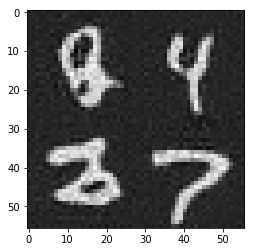

Epoch 2/2... Discriminator Loss: 0.5071... Generator Loss: 1.2724
Epoch 2/2... Discriminator Loss: 2.5071... Generator Loss: 0.2101
Epoch 2/2... Discriminator Loss: 1.2909... Generator Loss: 0.6914
Epoch 2/2... Discriminator Loss: 0.4978... Generator Loss: 1.4590
Epoch 2/2... Discriminator Loss: 0.5831... Generator Loss: 1.0451
Epoch 2/2... Discriminator Loss: 0.1969... Generator Loss: 1.9337
Epoch 2/2... Discriminator Loss: 0.5054... Generator Loss: 1.5384
Epoch 2/2... Discriminator Loss: 1.2174... Generator Loss: 0.6374
Epoch 2/2... Discriminator Loss: 0.2583... Generator Loss: 2.3916
Epoch 2/2... Discriminator Loss: 3.8918... Generator Loss: 0.0321


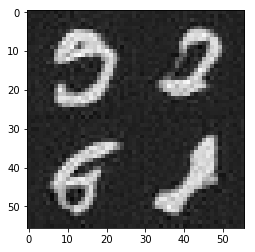

Epoch 2/2... Discriminator Loss: 2.3629... Generator Loss: 0.1696
Epoch 2/2... Discriminator Loss: 3.5014... Generator Loss: 0.0720
Epoch 2/2... Discriminator Loss: 0.3384... Generator Loss: 1.4482
Epoch 2/2... Discriminator Loss: 1.0161... Generator Loss: 1.2640
Epoch 2/2... Discriminator Loss: 0.6426... Generator Loss: 1.3256
Epoch 2/2... Discriminator Loss: 1.5040... Generator Loss: 0.4506
Epoch 2/2... Discriminator Loss: 0.3087... Generator Loss: 1.4280
Epoch 2/2... Discriminator Loss: 0.8704... Generator Loss: 1.1916
Epoch 2/2... Discriminator Loss: 2.5078... Generator Loss: 0.1493
Epoch 2/2... Discriminator Loss: 0.3198... Generator Loss: 2.8672


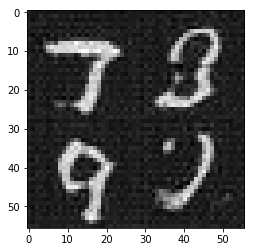

Epoch 2/2... Discriminator Loss: 0.6606... Generator Loss: 4.8562
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 4.0320
Epoch 2/2... Discriminator Loss: 0.1866... Generator Loss: 4.9594
Epoch 2/2... Discriminator Loss: 0.2966... Generator Loss: 2.4610
Epoch 2/2... Discriminator Loss: 2.5439... Generator Loss: 0.1167
Epoch 2/2... Discriminator Loss: 1.4757... Generator Loss: 0.3081
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.0044
Epoch 2/2... Discriminator Loss: 0.1173... Generator Loss: 2.7274
Epoch 2/2... Discriminator Loss: 0.0948... Generator Loss: 2.7578
Epoch 2/2... Discriminator Loss: 0.1912... Generator Loss: 2.2839


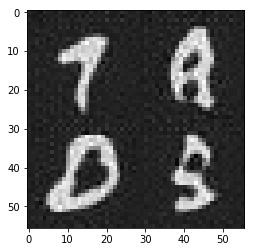

Epoch 2/2... Discriminator Loss: 1.6495... Generator Loss: 0.4547
Epoch 2/2... Discriminator Loss: 1.1326... Generator Loss: 0.5813
Epoch 2/2... Discriminator Loss: 2.2425... Generator Loss: 0.2653
Epoch 2/2... Discriminator Loss: 1.9092... Generator Loss: 0.1950
Epoch 2/2... Discriminator Loss: 1.8096... Generator Loss: 0.2408
Epoch 2/2... Discriminator Loss: 1.0152... Generator Loss: 0.5654
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 0.8089
Epoch 2/2... Discriminator Loss: 0.2028... Generator Loss: 2.1771
Epoch 2/2... Discriminator Loss: 0.1526... Generator Loss: 2.9868
Epoch 2/2... Discriminator Loss: 1.1728... Generator Loss: 0.6336


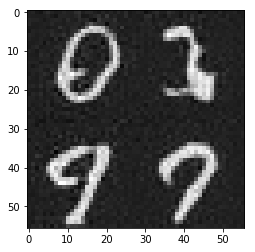

Epoch 2/2... Discriminator Loss: 2.0084... Generator Loss: 0.1862
Epoch 2/2... Discriminator Loss: 2.1026... Generator Loss: 0.1664
Epoch 2/2... Discriminator Loss: 0.6758... Generator Loss: 1.4863
Epoch 2/2... Discriminator Loss: 1.9205... Generator Loss: 0.4431
Epoch 2/2... Discriminator Loss: 1.1168... Generator Loss: 0.5910
Epoch 2/2... Discriminator Loss: 1.6898... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 2.5534... Generator Loss: 0.1012
Epoch 2/2... Discriminator Loss: 0.8195... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 0.4298
Epoch 2/2... Discriminator Loss: 4.8776... Generator Loss: 0.0128


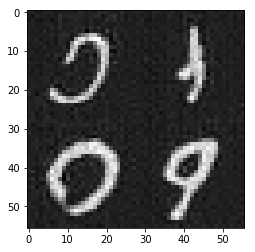

Epoch 2/2... Discriminator Loss: 1.0932... Generator Loss: 0.5362
Epoch 2/2... Discriminator Loss: 0.4591... Generator Loss: 1.4061
Epoch 2/2... Discriminator Loss: 0.3810... Generator Loss: 1.9616
Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 0.9764
Epoch 2/2... Discriminator Loss: 0.6494... Generator Loss: 1.1842
Epoch 2/2... Discriminator Loss: 0.7699... Generator Loss: 0.8056
Epoch 2/2... Discriminator Loss: 2.0000... Generator Loss: 0.2049
Epoch 2/2... Discriminator Loss: 0.2870... Generator Loss: 1.6146
Epoch 2/2... Discriminator Loss: 0.0324... Generator Loss: 4.2253
Epoch 2/2... Discriminator Loss: 0.1987... Generator Loss: 2.1462


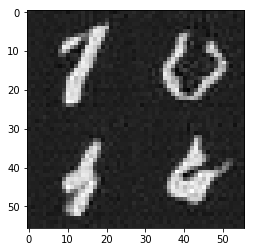

Epoch 2/2... Discriminator Loss: 0.0056... Generator Loss: 5.5626
Epoch 2/2... Discriminator Loss: 0.2016... Generator Loss: 2.6543
Epoch 2/2... Discriminator Loss: 0.0342... Generator Loss: 4.3685
Epoch 2/2... Discriminator Loss: 2.6190... Generator Loss: 0.1169
Epoch 2/2... Discriminator Loss: 0.4931... Generator Loss: 1.8427
Epoch 2/2... Discriminator Loss: 0.0321... Generator Loss: 4.2842
Epoch 2/2... Discriminator Loss: 0.6008... Generator Loss: 0.9123
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 0.6299
Epoch 2/2... Discriminator Loss: 2.1617... Generator Loss: 0.2430
Epoch 2/2... Discriminator Loss: 0.0906... Generator Loss: 3.9088


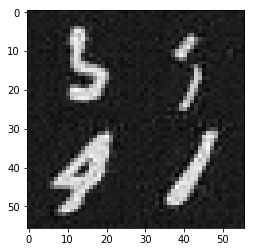

Epoch 2/2... Discriminator Loss: 0.0325... Generator Loss: 5.2863
Epoch 2/2... Discriminator Loss: 0.4034... Generator Loss: 1.5391
Epoch 2/2... Discriminator Loss: 0.5629... Generator Loss: 1.3573
Epoch 2/2... Discriminator Loss: 0.0439... Generator Loss: 3.9201
Epoch 2/2... Discriminator Loss: 0.2161... Generator Loss: 2.2751
Epoch 2/2... Discriminator Loss: 0.1664... Generator Loss: 3.7936
Epoch 2/2... Discriminator Loss: 1.7645... Generator Loss: 0.2575
Epoch 2/2... Discriminator Loss: 0.2950... Generator Loss: 2.3894
Epoch 2/2... Discriminator Loss: 0.8932... Generator Loss: 0.8675
Epoch 2/2... Discriminator Loss: 1.0192... Generator Loss: 0.7207


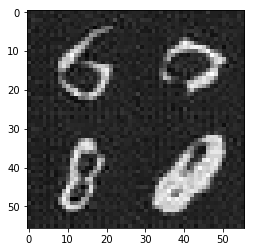

Epoch 2/2... Discriminator Loss: 0.6871... Generator Loss: 1.2123
Epoch 2/2... Discriminator Loss: 1.2529... Generator Loss: 0.4379
Epoch 2/2... Discriminator Loss: 1.1679... Generator Loss: 0.5083
Epoch 2/2... Discriminator Loss: 0.4838... Generator Loss: 1.3731
Epoch 2/2... Discriminator Loss: 1.5612... Generator Loss: 0.5016
Epoch 2/2... Discriminator Loss: 1.9299... Generator Loss: 0.3000
Epoch 2/2... Discriminator Loss: 0.1352... Generator Loss: 2.8224
Epoch 2/2... Discriminator Loss: 0.7874... Generator Loss: 1.7730
Epoch 2/2... Discriminator Loss: 1.1366... Generator Loss: 0.5868
Epoch 2/2... Discriminator Loss: 1.2440... Generator Loss: 1.0228


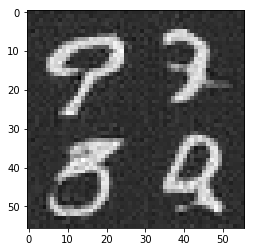

Epoch 2/2... Discriminator Loss: 0.4593... Generator Loss: 1.2984
Epoch 2/2... Discriminator Loss: 0.3078... Generator Loss: 1.4042
Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 0.8185
Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 0.6361
Epoch 2/2... Discriminator Loss: 1.0361... Generator Loss: 0.5990
Epoch 2/2... Discriminator Loss: 0.2061... Generator Loss: 2.7135
Epoch 2/2... Discriminator Loss: 2.1642... Generator Loss: 0.1621
Epoch 2/2... Discriminator Loss: 0.1934... Generator Loss: 2.1933
Epoch 2/2... Discriminator Loss: 2.0997... Generator Loss: 0.3077
Epoch 2/2... Discriminator Loss: 1.7238... Generator Loss: 0.3330


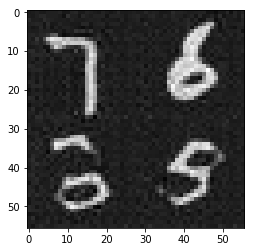

Epoch 2/2... Discriminator Loss: 0.2155... Generator Loss: 1.8602
Epoch 2/2... Discriminator Loss: 1.9198... Generator Loss: 0.3497
Epoch 2/2... Discriminator Loss: 0.4940... Generator Loss: 1.5013
Epoch 2/2... Discriminator Loss: 1.1333... Generator Loss: 0.4529
Epoch 2/2... Discriminator Loss: 1.5165... Generator Loss: 0.4471
Epoch 2/2... Discriminator Loss: 1.1636... Generator Loss: 0.6187
Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 0.5772
Epoch 2/2... Discriminator Loss: 0.9866... Generator Loss: 0.9709
Epoch 2/2... Discriminator Loss: 0.2969... Generator Loss: 1.7268
Epoch 2/2... Discriminator Loss: 0.5089... Generator Loss: 2.0190


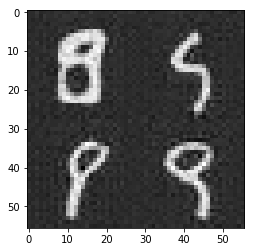

Epoch 2/2... Discriminator Loss: 0.4391... Generator Loss: 1.3116
Epoch 2/2... Discriminator Loss: 0.2332... Generator Loss: 2.4651
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 0.7619
Epoch 2/2... Discriminator Loss: 0.0157... Generator Loss: 5.5627
Epoch 2/2... Discriminator Loss: 1.5222... Generator Loss: 0.2727
Epoch 2/2... Discriminator Loss: 0.2290... Generator Loss: 2.7234
Epoch 2/2... Discriminator Loss: 0.1446... Generator Loss: 3.1200
Epoch 2/2... Discriminator Loss: 0.8358... Generator Loss: 0.6898
Epoch 2/2... Discriminator Loss: 0.2142... Generator Loss: 2.6011
Epoch 2/2... Discriminator Loss: 1.1492... Generator Loss: 0.5553


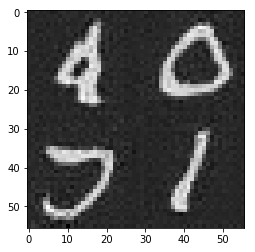

Epoch 2/2... Discriminator Loss: 0.2931... Generator Loss: 1.6527
Epoch 2/2... Discriminator Loss: 0.1214... Generator Loss: 2.8030
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 0.5262
Epoch 2/2... Discriminator Loss: 1.1673... Generator Loss: 1.0793
Epoch 2/2... Discriminator Loss: 1.6815... Generator Loss: 0.4829
Epoch 2/2... Discriminator Loss: 1.1751... Generator Loss: 0.8201
Epoch 2/2... Discriminator Loss: 1.4142... Generator Loss: 0.4004
Epoch 2/2... Discriminator Loss: 0.2818... Generator Loss: 1.8305
Epoch 2/2... Discriminator Loss: 0.2021... Generator Loss: 2.4066
Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 0.5340


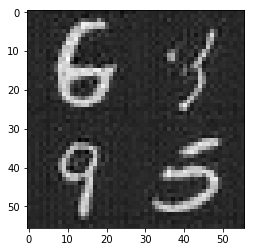

Epoch 2/2... Discriminator Loss: 2.2436... Generator Loss: 0.1904
Epoch 2/2... Discriminator Loss: 2.7412... Generator Loss: 0.1221
Epoch 2/2... Discriminator Loss: 1.1611... Generator Loss: 0.5482
Epoch 2/2... Discriminator Loss: 0.7446... Generator Loss: 1.2407
Epoch 2/2... Discriminator Loss: 0.1219... Generator Loss: 2.7440
Epoch 2/2... Discriminator Loss: 0.4940... Generator Loss: 1.5636
Epoch 2/2... Discriminator Loss: 2.5454... Generator Loss: 0.3746
Epoch 2/2... Discriminator Loss: 0.1255... Generator Loss: 2.8259
Epoch 2/2... Discriminator Loss: 0.1474... Generator Loss: 2.1128
Epoch 2/2... Discriminator Loss: 1.1909... Generator Loss: 0.6775


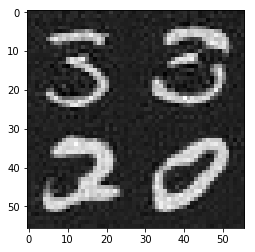

Epoch 2/2... Discriminator Loss: 1.1185... Generator Loss: 0.4441
Epoch 2/2... Discriminator Loss: 0.0546... Generator Loss: 3.4205
Epoch 2/2... Discriminator Loss: 1.0797... Generator Loss: 0.5156
Epoch 2/2... Discriminator Loss: 5.5689... Generator Loss: 0.0079
Epoch 2/2... Discriminator Loss: 4.6088... Generator Loss: 0.0238
Epoch 2/2... Discriminator Loss: 0.6069... Generator Loss: 1.4023
Epoch 2/2... Discriminator Loss: 0.3351... Generator Loss: 1.9277
Epoch 2/2... Discriminator Loss: 0.8273... Generator Loss: 0.7455
Epoch 2/2... Discriminator Loss: 2.4126... Generator Loss: 0.2068
Epoch 2/2... Discriminator Loss: 3.4606... Generator Loss: 0.0436


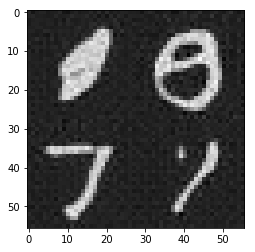

Epoch 2/2... Discriminator Loss: 1.3366... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 1.1697... Generator Loss: 0.5586
Epoch 2/2... Discriminator Loss: 0.4570... Generator Loss: 1.2916
Epoch 2/2... Discriminator Loss: 2.2141... Generator Loss: 0.1403
Epoch 2/2... Discriminator Loss: 0.0243... Generator Loss: 4.2506
Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 0.5511
Epoch 2/2... Discriminator Loss: 2.1456... Generator Loss: 0.2399
Epoch 2/2... Discriminator Loss: 0.0217... Generator Loss: 4.7215
Epoch 2/2... Discriminator Loss: 1.4939... Generator Loss: 0.4746
Epoch 2/2... Discriminator Loss: 1.8326... Generator Loss: 0.4764


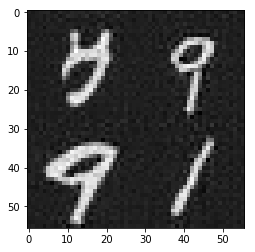

Epoch 2/2... Discriminator Loss: 4.2599... Generator Loss: 0.0232
Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 0.6360
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 1.0969
Epoch 2/2... Discriminator Loss: 3.6466... Generator Loss: 0.1010
Epoch 2/2... Discriminator Loss: 1.6215... Generator Loss: 0.2979
Epoch 2/2... Discriminator Loss: 3.2817... Generator Loss: 0.0455
Epoch 2/2... Discriminator Loss: 1.1444... Generator Loss: 3.8690
Epoch 2/2... Discriminator Loss: 0.9392... Generator Loss: 1.0503
Epoch 2/2... Discriminator Loss: 0.2190... Generator Loss: 2.4087
Epoch 2/2... Discriminator Loss: 2.1567... Generator Loss: 0.2931


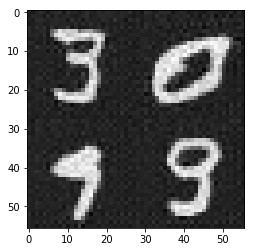

Epoch 2/2... Discriminator Loss: 1.5703... Generator Loss: 0.3819
Epoch 2/2... Discriminator Loss: 0.6790... Generator Loss: 0.9323
Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 1.4640
Epoch 2/2... Discriminator Loss: 1.3194... Generator Loss: 1.2880
Epoch 2/2... Discriminator Loss: 0.0197... Generator Loss: 5.2537
Epoch 2/2... Discriminator Loss: 0.3657... Generator Loss: 1.5990
Epoch 2/2... Discriminator Loss: 0.3632... Generator Loss: 1.5648
Epoch 2/2... Discriminator Loss: 0.0657... Generator Loss: 6.8740
Epoch 2/2... Discriminator Loss: 0.4648... Generator Loss: 1.9016
Epoch 2/2... Discriminator Loss: 0.1004... Generator Loss: 3.3239


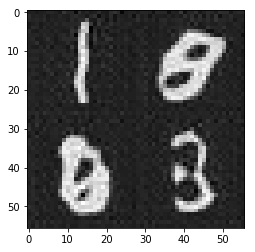

Epoch 2/2... Discriminator Loss: 1.8881... Generator Loss: 0.3236
Epoch 2/2... Discriminator Loss: 1.0922... Generator Loss: 1.2045
Epoch 2/2... Discriminator Loss: 0.2377... Generator Loss: 2.6836
Epoch 2/2... Discriminator Loss: 2.7722... Generator Loss: 0.1601
Epoch 2/2... Discriminator Loss: 1.7276... Generator Loss: 0.5042
Epoch 2/2... Discriminator Loss: 0.5114... Generator Loss: 1.4469
Epoch 2/2... Discriminator Loss: 3.8625... Generator Loss: 0.0534
Epoch 2/2... Discriminator Loss: 0.2970... Generator Loss: 1.4500
Epoch 2/2... Discriminator Loss: 2.6594... Generator Loss: 0.1268
Epoch 2/2... Discriminator Loss: 1.1594... Generator Loss: 0.6307


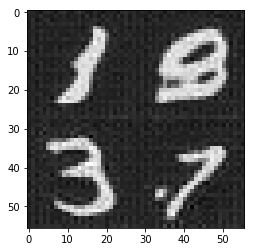

Epoch 2/2... Discriminator Loss: 1.6010... Generator Loss: 0.5313
Epoch 2/2... Discriminator Loss: 0.8627... Generator Loss: 0.6751
Epoch 2/2... Discriminator Loss: 0.6896... Generator Loss: 1.1335
Epoch 2/2... Discriminator Loss: 1.5220... Generator Loss: 0.3673
Epoch 2/2... Discriminator Loss: 1.6534... Generator Loss: 0.9972
Epoch 2/2... Discriminator Loss: 1.0337... Generator Loss: 0.8567
Epoch 2/2... Discriminator Loss: 1.0212... Generator Loss: 0.9095
Epoch 2/2... Discriminator Loss: 2.9292... Generator Loss: 0.0944
Epoch 2/2... Discriminator Loss: 1.4149... Generator Loss: 0.4473
Epoch 2/2... Discriminator Loss: 0.9119... Generator Loss: 0.8994


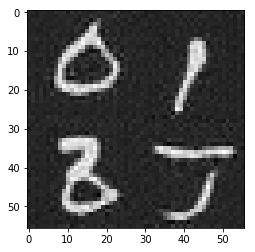

Epoch 2/2... Discriminator Loss: 1.6184... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 0.6661... Generator Loss: 1.0999
Epoch 2/2... Discriminator Loss: 0.8558... Generator Loss: 5.3654
Epoch 2/2... Discriminator Loss: 0.7539... Generator Loss: 1.6192
Epoch 2/2... Discriminator Loss: 0.6090... Generator Loss: 1.7733
Epoch 2/2... Discriminator Loss: 1.5558... Generator Loss: 0.6383
Epoch 2/2... Discriminator Loss: 0.2681... Generator Loss: 1.9399
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 0.8525
Epoch 2/2... Discriminator Loss: 0.4637... Generator Loss: 1.2775
Epoch 2/2... Discriminator Loss: 1.9340... Generator Loss: 0.3291


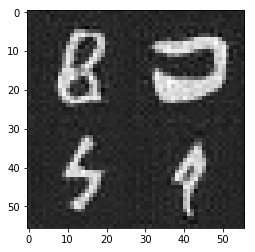

Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 0.7255
Epoch 2/2... Discriminator Loss: 1.7023... Generator Loss: 0.2960
Epoch 2/2... Discriminator Loss: 0.3772... Generator Loss: 2.2992
Epoch 2/2... Discriminator Loss: 0.1586... Generator Loss: 6.7505
Epoch 2/2... Discriminator Loss: 0.7704... Generator Loss: 0.9199
Epoch 2/2... Discriminator Loss: 0.9265... Generator Loss: 0.9215
Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 0.9024
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 0.4521
Epoch 2/2... Discriminator Loss: 1.6759... Generator Loss: 0.3276
Epoch 2/2... Discriminator Loss: 1.1492... Generator Loss: 0.6295


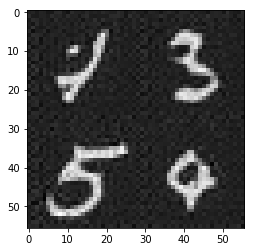

Epoch 2/2... Discriminator Loss: 1.2934... Generator Loss: 0.6551
Epoch 2/2... Discriminator Loss: 0.3566... Generator Loss: 2.8389
Epoch 2/2... Discriminator Loss: 1.3787... Generator Loss: 0.3908
Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 1.0696
Epoch 2/2... Discriminator Loss: 1.8612... Generator Loss: 0.3167
Epoch 2/2... Discriminator Loss: 1.0319... Generator Loss: 0.7800
Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 0.4693
Epoch 2/2... Discriminator Loss: 0.1371... Generator Loss: 2.4759
Epoch 2/2... Discriminator Loss: 1.7370... Generator Loss: 0.2994
Epoch 2/2... Discriminator Loss: 0.8426... Generator Loss: 0.8207


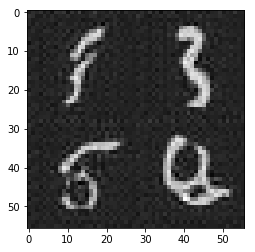

Epoch 2/2... Discriminator Loss: 0.5463... Generator Loss: 1.4229
Epoch 2/2... Discriminator Loss: 0.6229... Generator Loss: 1.2618
Epoch 2/2... Discriminator Loss: 0.3819... Generator Loss: 1.6699
Epoch 2/2... Discriminator Loss: 1.5630... Generator Loss: 0.3401
Epoch 2/2... Discriminator Loss: 4.5539... Generator Loss: 0.0141
Epoch 2/2... Discriminator Loss: 0.6861... Generator Loss: 0.9548
Epoch 2/2... Discriminator Loss: 1.5824... Generator Loss: 0.4626
Epoch 2/2... Discriminator Loss: 0.2599... Generator Loss: 1.9374
Epoch 2/2... Discriminator Loss: 0.7652... Generator Loss: 0.6791
Epoch 2/2... Discriminator Loss: 0.0326... Generator Loss: 4.2141


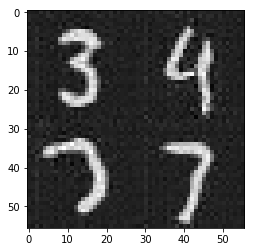

Epoch 2/2... Discriminator Loss: 0.5265... Generator Loss: 1.2257
Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 1.3608
Epoch 2/2... Discriminator Loss: 0.2481... Generator Loss: 2.7592
Epoch 2/2... Discriminator Loss: 3.5792... Generator Loss: 0.0437
Epoch 2/2... Discriminator Loss: 1.2717... Generator Loss: 0.4956
Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 0.8969
Epoch 2/2... Discriminator Loss: 0.1477... Generator Loss: 2.7583
Epoch 2/2... Discriminator Loss: 0.0278... Generator Loss: 4.1645
Epoch 2/2... Discriminator Loss: 4.3324... Generator Loss: 0.0527
Epoch 2/2... Discriminator Loss: 2.4726... Generator Loss: 0.5680


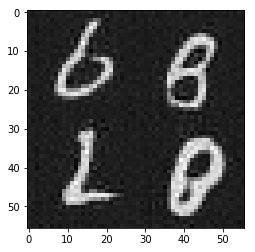

Epoch 2/2... Discriminator Loss: 0.5158... Generator Loss: 1.8667
Epoch 2/2... Discriminator Loss: 1.0683... Generator Loss: 0.4410
Epoch 2/2... Discriminator Loss: 0.3484... Generator Loss: 1.5177
Epoch 2/2... Discriminator Loss: 0.3188... Generator Loss: 1.8340
Epoch 2/2... Discriminator Loss: 3.2756... Generator Loss: 0.0614
Epoch 2/2... Discriminator Loss: 2.0935... Generator Loss: 0.2895
Epoch 2/2... Discriminator Loss: 0.6337... Generator Loss: 1.3705
Epoch 2/2... Discriminator Loss: 2.5245... Generator Loss: 0.1212
Epoch 2/2... Discriminator Loss: 3.2607... Generator Loss: 0.0655
Epoch 2/2... Discriminator Loss: 3.0069... Generator Loss: 0.2347


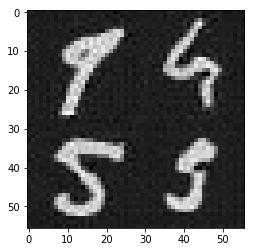

Epoch 2/2... Discriminator Loss: 1.0790... Generator Loss: 0.7501
Epoch 2/2... Discriminator Loss: 1.2713... Generator Loss: 0.5199
Epoch 2/2... Discriminator Loss: 0.1168... Generator Loss: 2.4834
Epoch 2/2... Discriminator Loss: 1.9245... Generator Loss: 0.6677
Epoch 2/2... Discriminator Loss: 0.4580... Generator Loss: 1.5458
Epoch 2/2... Discriminator Loss: 1.2907... Generator Loss: 0.5274
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 0.9075
Epoch 2/2... Discriminator Loss: 0.4628... Generator Loss: 1.8791
Epoch 2/2... Discriminator Loss: 3.1319... Generator Loss: 0.0703
Epoch 2/2... Discriminator Loss: 3.8153... Generator Loss: 0.0271


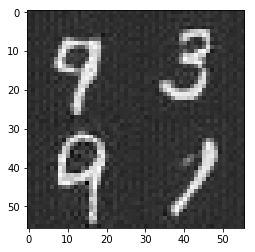

Epoch 2/2... Discriminator Loss: 2.2170... Generator Loss: 0.1378
Epoch 2/2... Discriminator Loss: 1.5932... Generator Loss: 0.3176
Epoch 2/2... Discriminator Loss: 0.9047... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 1.0776... Generator Loss: 0.6911
Epoch 2/2... Discriminator Loss: 3.0095... Generator Loss: 0.1244
Epoch 2/2... Discriminator Loss: 0.7790... Generator Loss: 1.3243
Epoch 2/2... Discriminator Loss: 1.6986... Generator Loss: 0.3755
Epoch 2/2... Discriminator Loss: 0.0879... Generator Loss: 3.0871
Epoch 2/2... Discriminator Loss: 0.5301... Generator Loss: 1.0585
Epoch 2/2... Discriminator Loss: 0.1648... Generator Loss: 2.0879


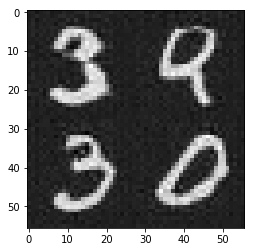

Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.5079
Epoch 2/2... Discriminator Loss: 0.3659... Generator Loss: 1.4250
Epoch 2/2... Discriminator Loss: 3.8832... Generator Loss: 0.1306
Epoch 2/2... Discriminator Loss: 1.9110... Generator Loss: 0.6138
Epoch 2/2... Discriminator Loss: 1.4783... Generator Loss: 0.3832
Epoch 2/2... Discriminator Loss: 2.0568... Generator Loss: 0.2188
Epoch 2/2... Discriminator Loss: 0.1995... Generator Loss: 2.8493
Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.4736
Epoch 2/2... Discriminator Loss: 1.8095... Generator Loss: 0.5132
Epoch 2/2... Discriminator Loss: 3.1658... Generator Loss: 0.0694


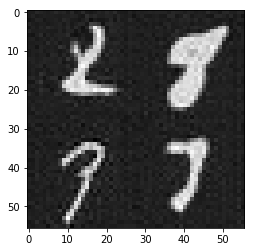

Epoch 2/2... Discriminator Loss: 1.8692... Generator Loss: 0.3110
Epoch 2/2... Discriminator Loss: 2.2106... Generator Loss: 0.3751
Epoch 2/2... Discriminator Loss: 0.8048... Generator Loss: 0.8605
Epoch 2/2... Discriminator Loss: 0.7252... Generator Loss: 1.1658
Epoch 2/2... Discriminator Loss: 0.3722... Generator Loss: 2.1466
Epoch 2/2... Discriminator Loss: 0.5374... Generator Loss: 2.4822
Epoch 2/2... Discriminator Loss: 1.3453... Generator Loss: 0.7747
Epoch 2/2... Discriminator Loss: 1.6732... Generator Loss: 0.6626
Epoch 2/2... Discriminator Loss: 4.8736... Generator Loss: 0.0092
Epoch 2/2... Discriminator Loss: 2.2339... Generator Loss: 0.4294


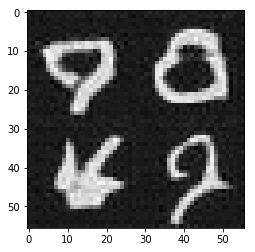

Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 0.8256
Epoch 2/2... Discriminator Loss: 2.3989... Generator Loss: 0.4088
Epoch 2/2... Discriminator Loss: 1.5772... Generator Loss: 0.2877
Epoch 2/2... Discriminator Loss: 2.8386... Generator Loss: 0.1552
Epoch 2/2... Discriminator Loss: 0.8927... Generator Loss: 0.7137
Epoch 2/2... Discriminator Loss: 2.0228... Generator Loss: 0.4336
Epoch 2/2... Discriminator Loss: 0.3530... Generator Loss: 1.2511
Epoch 2/2... Discriminator Loss: 0.1220... Generator Loss: 2.8529
Epoch 2/2... Discriminator Loss: 0.0955... Generator Loss: 3.0895
Epoch 2/2... Discriminator Loss: 2.1382... Generator Loss: 0.1902


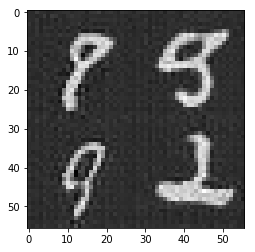

Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 4.2628
Epoch 2/2... Discriminator Loss: 1.7094... Generator Loss: 0.3482
Epoch 2/2... Discriminator Loss: 0.8629... Generator Loss: 0.6379
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 0.8619
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.6452
Epoch 2/2... Discriminator Loss: 0.3990... Generator Loss: 1.8362
Epoch 2/2... Discriminator Loss: 1.8464... Generator Loss: 0.3028
Epoch 2/2... Discriminator Loss: 0.1597... Generator Loss: 2.7886
Epoch 2/2... Discriminator Loss: 0.1754... Generator Loss: 2.0085
Epoch 2/2... Discriminator Loss: 0.7156... Generator Loss: 0.9567


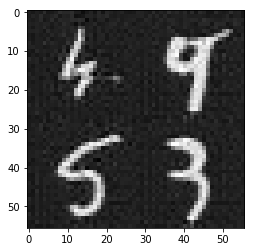

Epoch 2/2... Discriminator Loss: 0.1895... Generator Loss: 2.0112
Epoch 2/2... Discriminator Loss: 0.0443... Generator Loss: 4.7244
Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 0.6196
Epoch 2/2... Discriminator Loss: 0.1541... Generator Loss: 2.5945
Epoch 2/2... Discriminator Loss: 1.4266... Generator Loss: 0.4145
Epoch 2/2... Discriminator Loss: 2.6815... Generator Loss: 0.1407
Epoch 2/2... Discriminator Loss: 0.5147... Generator Loss: 1.5563
Epoch 2/2... Discriminator Loss: 0.0690... Generator Loss: 4.7704
Epoch 2/2... Discriminator Loss: 1.3684... Generator Loss: 0.7951
Epoch 2/2... Discriminator Loss: 1.7593... Generator Loss: 0.5281


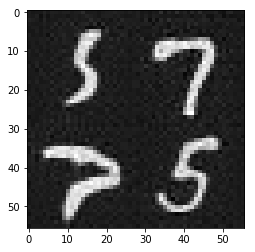

Epoch 2/2... Discriminator Loss: 0.2102... Generator Loss: 1.9620
Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 0.7469
Epoch 2/2... Discriminator Loss: 1.7258... Generator Loss: 0.3678
Epoch 2/2... Discriminator Loss: 0.0199... Generator Loss: 4.9521
Epoch 2/2... Discriminator Loss: 1.7506... Generator Loss: 0.3719
Epoch 2/2... Discriminator Loss: 1.5574... Generator Loss: 1.0676
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.4346
Epoch 2/2... Discriminator Loss: 0.5568... Generator Loss: 1.1871
Epoch 2/2... Discriminator Loss: 1.3721... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 2.1640... Generator Loss: 0.2068


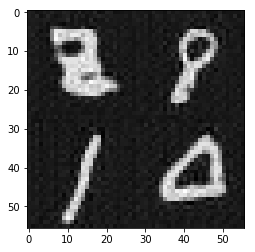

Epoch 2/2... Discriminator Loss: 3.6881... Generator Loss: 0.0463
Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 0.8857
Epoch 2/2... Discriminator Loss: 0.4269... Generator Loss: 2.0577
Epoch 2/2... Discriminator Loss: 1.1777... Generator Loss: 1.0102
Epoch 2/2... Discriminator Loss: 0.7254... Generator Loss: 1.0964
Epoch 2/2... Discriminator Loss: 2.1435... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 0.5339... Generator Loss: 1.7510
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.3951
Epoch 2/2... Discriminator Loss: 2.2682... Generator Loss: 0.2042
Epoch 2/2... Discriminator Loss: 0.4827... Generator Loss: 1.0313


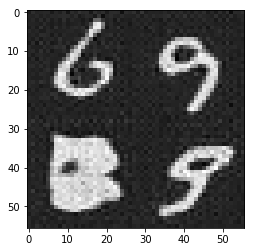

IndexError: list index out of range

In [137]:
batch_size = 8
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.